### Source of the datasets
There are 4 databases: airports, carriers, plane-data, 2007.  <br>
Source of the dataset comes from the [2009 Data Expo](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009). <br>
Information and description regarding the varibles came be found [here](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGK).

Each database has a column with a unique identifier:
|csv|identifier column|maps to |Notes|
|---|---|---|---|
|airports|iata|Origin, Dest||
|carriers|code |UniqueCarrier| (some are "duplicated" with a (1) for codes that are the same)|
|plane-data|tailnum| TailNum ||

Steps:
1. Upload all the CSV files via WinSCP
2. Upload them onto hdfs. Run `hdfs dfs -put *.csv /user/maria_dev/` to put all the csv to HDFS. Change path and replace * if needed.
3. `spark-submit` this .py file:
   ```
   from pyspark.sql import SparkSession
   from pyspark.sql.functions import col
   from pyspark.sql.types import IntegerType
   
   spark = SparkSession.builder \
    .appName("CSV to Hive") \
    .enableHiveSupport() \
    .getOrCreate()

   ## read all csv files
   df_car = spark.read.option("header", "true").csv("hdfs:///user/maria_dev/carriers.csv")
   df_air = spark.read.option("header", "true").csv("hdfs:///user/maria_dev/airports.csv")
   df_plane = spark.read.option("header","true").csv("hdfs:///user/maria_dev/plane-data.csv")
   f_2007 = spark.read.option("header","true").csv("hdfs:///user/maria_dev/2007.csv")

   #change data type
   ccol = ["Year", "Month", "DayofMonth", "DayOfWeek","DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "ActualElapsedTime", "CRSElapsedTime", "AirTime","ArrDelay","DepDelay","Distance","TaxiIn", "TaxiOut", "Cancelled", "Diverted","CarrierDelay", "WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]
   for col_name in ccol:
       df_2007 = df_2007.withColumn(col_name, col(col_name).cast(IntegerType()))
   ## write them into hive tables
   df_car.write.mode("overwrite").saveAsTable("carriers")
   df_air.write.mode("overwrite").saveAsTable("airports")
   df_plane.write.mode("overwrite").saveAsTable("plane_data")
   df_2007.write.mode("overwrite").saveAsTable("year_2007")
   ```


In [2]:
#Loading packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Function to convert cursor.executed queries into dataframe
def to_pd(cursor):
  columns = [desc[0] for desc in cursor.description]
  data = cursor.fetchall()
  return pd.DataFrame(data, columns=columns)

In [196]:
# reload this every time it disconnects from session
#connect to hive
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism = 'PLAIN'
)
cursor = conn.cursor()

## General Overview

In [9]:
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism = 'PLAIN'
)
cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('airports',), ('carriers',), ('plane_data',), ('year_2007',)]


In [6]:
import csv

with open("archive/2007.csv", newline='') as f:
    reader = csv.reader(f)
    header = next(reader)
    num_cols = len(header)
    num_rows = sum(1 for row in reader)

print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 7453215, Columns: 29


In [10]:
# Checking to see if number of rows matches original data
cursor.execute('SELECT COUNT(*) FROM year_2007')
cursor.fetchall()

[(7453215,)]

In [7]:
cursor.execute('SELECT COUNT(*) FROM plane_data')
cursor.fetchall()

[(5029,)]

In [2]:
cursor.execute('SELECT * FROM carriers LIMIT 10')
cursor.fetchall()

[('02Q', 'Titan Airways'),
 ('04Q', 'Tradewind Aviation'),
 ('05Q', 'Comlux Aviation, AG'),
 ('06Q', 'Master Top Linhas Aereas Ltd.'),
 ('07Q', 'Flair Airlines Ltd.'),
 ('09Q', 'Swift Air, LLC'),
 ('0BQ', 'DCA'),
 ('0CQ', 'ACM AIR CHARTER GmbH'),
 ('0FQ', 'Maine Aviation Aircraft Charter, LLC'),
 ('0GQ', 'Inter Island Airways, d/b/a Inter Island Air')]

## Delay Patterns

In [114]:
cursor.execute("SELECT * FROM year_2007 LIMIT 15")
df_ori = to_pd(cursor)
df_ori.iloc[:,6:21]

,year_2007.arrtime,year_2007.crsarrtime,year_2007.uniquecarrier,year_2007.flightnum,year_2007.tailnum,year_2007.actualelapsedtime,year_2007.crselapsedtime,year_2007.airtime,year_2007.arrdelay,year_2007.depdelay,year_2007.origin,year_2007.dest,year_2007.distance,year_2007.taxiin,year_2007.taxiout
0,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11
1,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6
2,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9
3,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8
4,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9
5,1553,1550,WN,2386,N611SW,83,90,74,3,10,SMF,PDX,479,2,7
6,2217,2130,WN,409,N482,101,110,89,47,56,SMF,PHX,647,5,7
7,1223,1225,WN,1131,N749SW,99,110,86,-2,9,SMF,PHX,647,4,9
8,1819,1735,WN,1212,N451,102,105,90,44,47,SMF,PHX,647,5,7
9,1603,1610,WN,2456,N630WN,105,115,92,-7,3,SMF,PHX,647,5,8


In [31]:
df_ori.iloc[:,22:]

,year_2007.cancellationcode,year_2007.diverted,year_2007.carrierdelay,year_2007.weatherdelay,year_2007.nasdelay,year_2007.securitydelay,year_2007.lateaircraftdelay
0,None,0,0,0,0,0,0
1,None,0,0,0,0,0,0
2,None,0,3,0,0,0,31
3,None,0,23,0,0,0,3
4,None,0,0,0,0,0,0
5,None,0,0,0,0,0,0
6,None,0,46,0,0,0,1
7,None,0,0,0,0,0,0
8,None,0,20,0,0,0,24
9,None,0,0,0,0,0,0


### Time of day

Morning is the least likely to have a delay during departure with a 5 minute delay, followed after by the afternoon with a 14 minute delay and the evening flights which have an average delay of 18 minutes.

In [6]:
cursor.execute("""SELECT
CASE
WHEN crsdeptime >= 0 AND crsdeptime < 1200 THEN 'Morning'
WHEN crsdeptime >= 1200 AND crsdeptime < 1800 THEN 'Afternoon'
WHEN crsdeptime >= 1800 AND crsdeptime <= 2359 THEN 'Evening'
ELSE 'Unknown'
END AS time_of_day,
AVG(depdelay) AS avg_depdelay
FROM year_2007
GROUP BY
CASE
WHEN crsdeptime >= 0 AND crsdeptime < 1200 THEN 'Morning'
WHEN crsdeptime >= 1200 AND crsdeptime < 1800 THEN 'Afternoon'
WHEN crsdeptime >= 1800 AND crsdeptime <= 2359 THEN 'Evening'
ELSE 'Unknown'
END""")
cursor.fetchall()

[('Afternoon', 14.123132596629342),
 ('Evening', 18.339562206363954),
 ('Morning', 5.3675000741762355)]

This still doesn't change when removing the early morning flights from 00:00 to 4:59. Early morning flights and morning flights only have around a 5 minute delay.

In [10]:
cursor.execute("""SELECT
CASE
WHEN crsdeptime >= 0 AND crsdeptime < 500 THEN 'Early Morning'
WHEN crsdeptime >= 500 AND crsdeptime < 1200 THEN 'Morning'
WHEN crsdeptime >= 1200 AND crsdeptime < 1800 THEN 'Afternoon'
WHEN crsdeptime >= 1800 AND crsdeptime <= 2359 THEN 'Evening'
ELSE 'Unknown'
END AS time_of_day,
AVG(depdelay) AS avg_depdelay
FROM year_2007
GROUP BY
CASE
WHEN crsdeptime >= 0 AND crsdeptime < 500 THEN 'Early Morning'
WHEN crsdeptime >= 500 AND crsdeptime < 1200 THEN 'Morning'
WHEN crsdeptime >= 1200 AND crsdeptime < 1800 THEN 'Afternoon'
WHEN crsdeptime >= 1800 AND crsdeptime <= 2359 THEN 'Evening'
ELSE 'Unknown'
END""")
cursor.fetchall()

[('Afternoon', 14.123132596629342),
 ('Early Morning', 6.2339689173305475),
 ('Evening', 18.339562206363954),
 ('Morning', 5.363053769076088)]

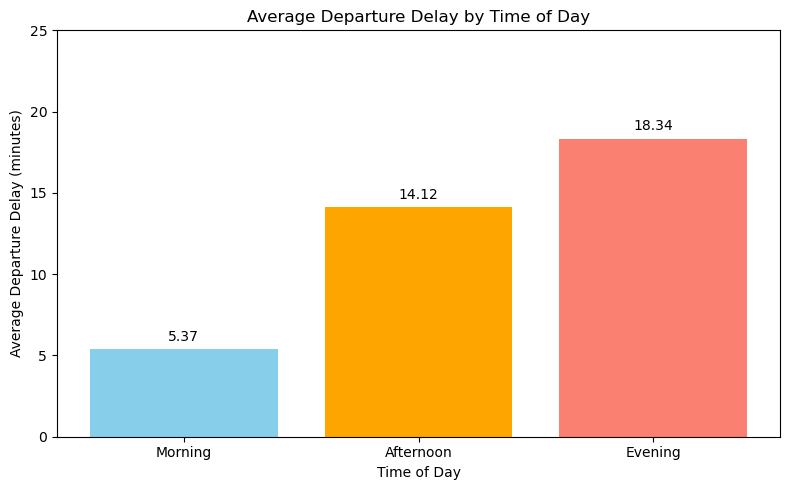

In [14]:

plt.figure(figsize=(8, 5))
plt.bar( ['Morning', 'Afternoon', 'Evening'],  [5.37, 14.12, 18.34], color=['skyblue', 'orange', 'salmon'])
plt.xlabel('Time of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Time of Day')
plt.ylim(0, 25)
plt.text(0, 5.37 + 0.5, 5.37, ha='center')
plt.text(1, 14.12 + 0.5, 14.12, ha='center')
plt.text(2, 18.34 + 0.5, 18.34, ha='center')

plt.tight_layout()
plt.show()

In [22]:
cursor.execute("""SELECT
CASE
WHEN crsarrtime >= 0 AND crsarrtime < 1200 THEN 'Morning'
WHEN crsarrtime >= 1200 AND crsarrtime < 1800 THEN 'Afternoon'
WHEN crsarrtime >= 1800 AND crsarrtime <= 2359 THEN 'Evening'
ELSE 'Unknown'
END AS time_of_day,
AVG(arrdelay) AS avg_depdelay
FROM year_2007
GROUP BY
CASE
WHEN crsarrtime >= 0 AND crsarrtime < 1200 THEN 'Morning'
WHEN crsarrtime >= 1200 AND crsarrtime < 1800 THEN 'Afternoon'
WHEN crsarrtime >= 1800 AND crsarrtime <= 2359 THEN 'Evening'
ELSE 'Unknown'
END""")
df = to_pd(cursor)

In [25]:
df = df.dropna(subset=['avg_depdelay'])
df

,time_of_day,avg_depdelay
0,Afternoon,9.583522
1,Evening,16.888411
2,Morning,3.653419


For arrival times, the lowest average delays follows the same pattern as the departure delays, i.e. morning, afternoon evening. However, there ia on average less delay on arrival than in departure, meaning that some of the lost minutes during the departure delays was regained during flight.

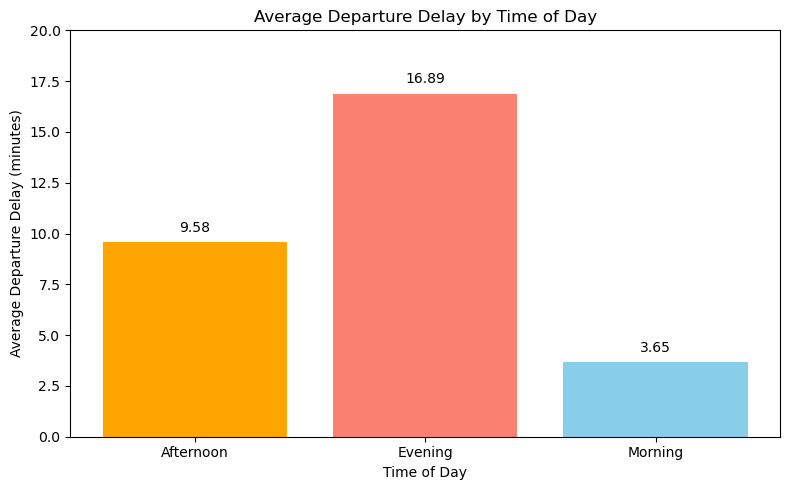

In [28]:
plt.figure(figsize=(8, 5))
plt.bar(df['time_of_day'], df['avg_depdelay'], color=['orange', 'salmon', 'skyblue'])
plt.xlabel('Time of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Time of Day')
plt.ylim(0, 20)
for i, value in enumerate(df['avg_depdelay']):
    plt.text(i, value + 0.5, f"{value:.2f}", ha='center')

plt.tight_layout()
plt.show()

### Day of the week

In [35]:
#checking what kind of values are inside dayofweek column
cursor.execute("""SELECT dayofweek, COUNT(*) AS f
FROM year_2007
GROUP BY dayofweek
ORDER BY f DESC""")
cursor.fetchall()

[(1, 1112474),
 (5, 1101689),
 (4, 1097738),
 (3, 1088858),
 (2, 1078562),
 (7, 1040556),
 (6, 933338)]

In [5]:
cursor.execute("""SELECT dayofweek,
AVG(depdelay) AS avg_depdelay,
AVG(arrdelay) AS avg_arrdelay
FROM year_2007
GROUP BY dayofweek
ORDER BY dayofweek""")
df = to_pd(cursor)
df

,dayofweek,avg_depdelay,avg_arrdelay
0,1,11.892416,10.513503
1,2,9.398721,8.263684
2,3,10.687133,9.962944
3,4,12.886387,12.685980
4,5,13.576725,13.067675
5,6,8.993705,5.846600
6,7,11.978119,10.329577


Looking at departure and arrival delay based on the day of the week, for 2007, Saturday and Tuesday at the least average delay of under 10 minutes. All others are around 10 minutes delay and higher with the highest being Thursday and Friday. It's also true that looking at pure frequency, there are less flights leaving Saturday (about 70000 flights less compared to the day with the second-least number of flights), so it could that there is less congestion.

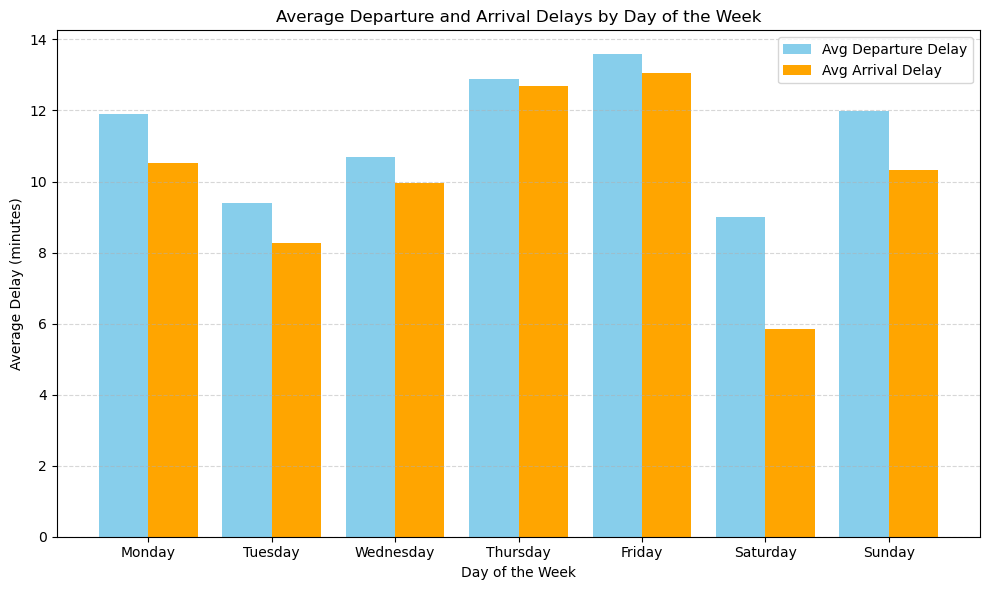

In [7]:
df['day_labels'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))

plt.bar([p - 0.4/2 for p in range(len(df))], df['avg_depdelay'], width=0.4, label='Avg Departure Delay', color='skyblue')
plt.bar([p + 0.4/2 for p in range(len(df))], df['avg_arrdelay'], width=0.4, label='Avg Arrival Delay', color='orange')

plt.xticks(range(len(df)), df['day_labels'])
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Departure and Arrival Delays by Day of the Week')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

r = 0.636, This indicates a moderate positive correlation between the number of flights and average departure delay. As number of flights increase, delays tend to increase as well. But with a p = 0.124, there is insufficient evidence to say that this isn't just due to chance. It's not statistically significant at the conventional 0.05 level or even the 0.1 level. 

In [8]:
from scipy.stats import pearsonr

df['total_flights']=[1112474, 1078562, 1088858, 1097738, 1101689, 933338, 1040556]

# Example: assuming `df` has 'flight_count' and 'avg_depdelay' columns
r, p_value = pearsonr(df['total_flights'], df['avg_depdelay'])
print(f"Pearson correlation: r = {r:.3f}, p-value = {p_value:.3g}")

Pearson correlation: r = 0.636, p-value = 0.124


In [9]:
df

,dayofweek,avg_depdelay,avg_arrdelay,day_labels,total_flights
0,1,11.892416,10.513503,Monday,1112474
1,2,9.398721,8.263684,Tuesday,1078562
2,3,10.687133,9.962944,Wednesday,1088858
3,4,12.886387,12.685980,Thursday,1097738
4,5,13.576725,13.067675,Friday,1101689
5,6,8.993705,5.846600,Saturday,933338
6,7,11.978119,10.329577,Sunday,1040556


### Month

In [15]:
cursor.execute("""SELECT month,
COUNT(*) AS total_flights,
AVG(depdelay) AS avg_depdelay,
AVG(arrdelay) AS avg_arrdelay
FROM year_2007
GROUP BY month
ORDER BY month""")
df = to_pd(cursor)
df

,month,total_flights,avg_depdelay,avg_arrdelay
0,1,621559,10.286743,9.162152
1,2,565604,14.022531,13.519795
2,3,639209,11.836803,10.084908
3,4,614648,10.077714,8.516230
4,5,631609,8.329205,7.037889
5,6,629280,16.214701,16.179528
6,7,648560,14.802614,14.107680
7,8,653279,13.515876,12.571533
8,9,600187,6.157686,3.749498
9,10,629992,7.973724,6.508259


In [16]:
df['month_label']=['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']

,month,total_flights,avg_depdelay,avg_arrdelay,month_label
0,1,621559,10.286743,9.162152,Jan
1,2,565604,14.022531,13.519795,Feb
2,3,639209,11.836803,10.084908,Mar
3,4,614648,10.077714,8.516230,Apr
4,5,631609,8.329205,7.037889,May
5,6,629280,16.214701,16.179528,Jun
6,7,648560,14.802614,14.107680,July
7,8,653279,13.515876,12.571533,Aug
8,9,600187,6.157686,3.749498,Sep
9,10,629992,7.973724,6.508259,Oct


December and June has the most delays at 16 minute delay average, while September, October, and November had the least delays at 6-8 minutes departure delay and 4-6 minutes arrival delay.

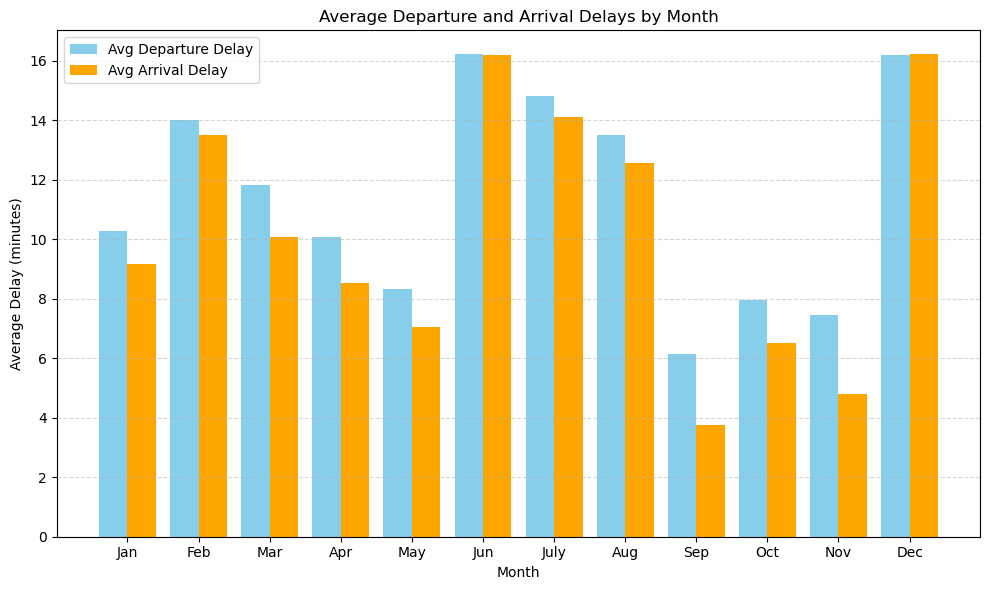

In [19]:
plt.figure(figsize=(10, 6))

plt.bar([p - 0.4/2 for p in range(len(df))], df['avg_depdelay'], width=0.4, label='Avg Departure Delay', color='skyblue')
plt.bar([p + 0.4/2 for p in range(len(df))], df['avg_arrdelay'], width=0.4, label='Avg Arrival Delay', color='orange')

plt.xticks(range(len(df)), df['month_label'])
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Departure and Arrival Delays by Month')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### Season

In [20]:
cursor.execute("""SELECT
  CASE
    WHEN month IN (12, 1, 2) THEN 'Winter'
    WHEN month IN (3, 4, 5) THEN 'Spring'
    WHEN month IN (6, 7, 8) THEN 'Summer'
    WHEN month IN (9, 10, 11) THEN 'Autumn'
  END AS season,
  COUNT(*) AS total_flights,
  AVG(depdelay) AS avg_depdelay,
  AVG(arrdelay) AS avg_arrdelay
FROM year_2007
GROUP BY
  CASE
    WHEN month IN (12, 1, 2) THEN 'Winter'
    WHEN month IN (3, 4, 5) THEN 'Spring'
    WHEN month IN (6, 7, 8) THEN 'Summer'
    WHEN month IN (9, 10, 11) THEN 'Autumn'
  END
ORDER BY season""")
df = to_pd(cursor)
df

,season,total_flights,avg_depdelay,avg_arrdelay
0,Autumn,1835328,7.205963,5.040201
1,Spring,1885466,10.078970,8.544794
2,Summer,1931119,14.823519,14.257590
3,Winter,1801302,13.463579,12.919023


The season with most delay on average is Summer (14 minutes) and Winter (13 minutes), the season with the least is during Autumn with only a 7 minute delay on average.

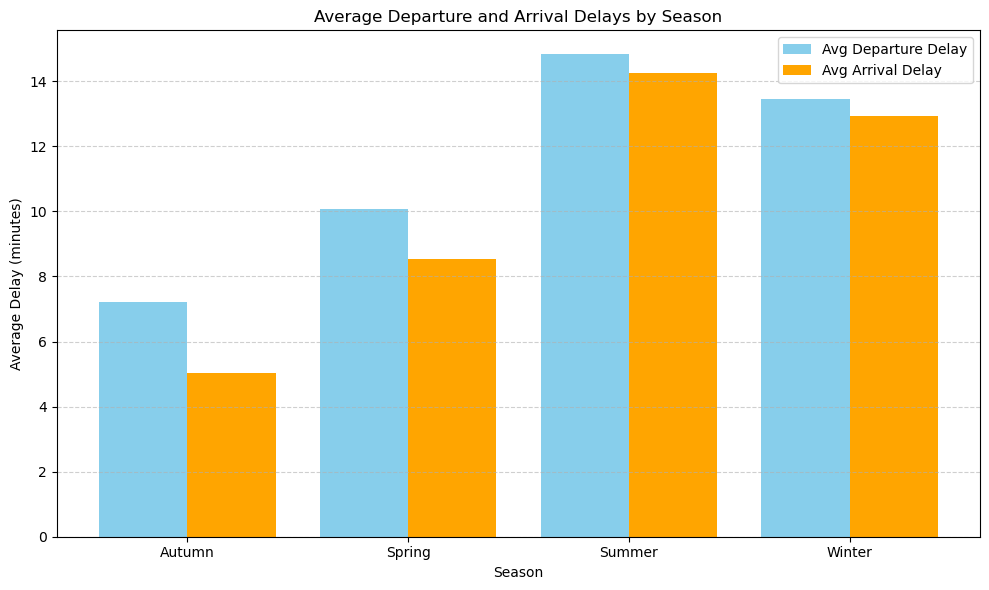

In [21]:
plt.figure(figsize=(10, 6))

plt.bar([p - 0.4/2 for p in range(len(df))], df['avg_depdelay'], width=0.4, label='Avg Departure Delay', color='skyblue')
plt.bar([p + 0.4/2 for p in range(len(df))], df['avg_arrdelay'], width=0.4, label='Avg Arrival Delay', color='orange')

plt.xticks(range(len(df)), df['season'])
plt.xlabel('Season')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Departure and Arrival Delays by Season')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## Delay Factors

Causes of delay include:
- Carrier Delay: Delays related to the carrier's operation and resources. e.g. maintenance issues, crew problems, or baggage handling delays.
- Weather Delay: Adverse weather conditions. Examples include rain, snow, fog, or strong winds. 
- NAS Delay: Delays related to the National Airspace System, such as air traffic control issues, heavy traffic volume, or non-extreme weather conditions affecting the overall system. 
- Security Delay: Security-related incidents, such as terminal evacuations, security breaches, or issues with screening equipment. 
- Late Aircraft Delay: Delays due to a previous delay, maintenance, or other operational issues with the inbound flight. 

LateAircraftDelay (38004942) and CarrierDelay (28808434) are the two factors that cause the most total delay overall. With SecurityDelay being the least at 176906 total minutes for 2007.

In [15]:
cursor.execute("""SELECT
SUM(CarrierDelay) AS total_carrier_delay,
SUM(WeatherDelay) AS total_weather_delay,
SUM(NASDelay) AS total_nas_delay,
SUM(SecurityDelay) AS total_security_delay,
SUM(LateAircraftDelay) AS total_late_aircraft_delay
FROM year_2007
WHERE (CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay) > 0""")
cursor.fetchall()

[(28808434, 5739649, 28200746, 176906, 38004942)]

If the delay caused by the carrier, it causes a delay of 35.35116 minutes.

In [11]:
cursor.execute("SELECT AVG(CarrierDelay) as CD FROM year_2007 WHERE CarrierDelay > 0")
cursor.fetchall()

[(35.351155079872676,)]

If the delay caused by the weather, it causes a delay of 44.89397 minutes.

In [16]:
cursor.execute("SELECT AVG(WeatherDelay) as CD FROM year_2007 WHERE WeatherDelay > 0")
cursor.fetchall()

[(44.89396866616086,)]

If the delay caused by the NAS, it causes a delay of 27.00556 minutes.

In [17]:
cursor.execute("SELECT AVG(NASDelay) as CD FROM year_2007 WHERE NASDelay > 0")
cursor.fetchall()


[(27.00556089161959,)]

If the delay caused by Security, it causes a delay of 19.08577 minutes.

In [18]:
cursor.execute("SELECT AVG(SecurityDelay) as CD FROM year_2007 WHERE SecurityDelay > 0")
cursor.fetchall()


[(19.085769770201747,)]

If the delay caused by late aircraft, it causes a delay of 45.31957 minutes.

In [19]:
cursor.execute("SELECT AVG(LateAircraftDelay) as CD FROM year_2007 WHERE LateAircraftDelay > 0")
cursor.fetchall()


[(45.3195651318449,)]

There were 5649895 flights not affected by delay with the remaining 1803320 affected by delay.

In [21]:
cursor.execute("""SELECT COUNT(*) 
FROM year_2007
WHERE (CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay) = 0""")
cursor.fetchall()

[(5649895,)]

In [22]:
cursor.execute("""SELECT COUNT(*) 
FROM year_2007
WHERE (CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay) > 0""")
cursor.fetchall()

[(1803320,)]

Out of those 1803320, 0.451900938 (45.19%) had delays due to carrier delay, 0.070896458 (7%) was from the weather, 0.579074707 (57%) was from NAS, 0.005139964 (0.5%) was from Security and 0.465030610 (46.5) was from late aircrafts.

In [28]:
cursor.execute("""SELECT
  SUM(CASE WHEN CarrierDelay = 0 THEN 1 ELSE 0 END) AS zero,
  SUM(CASE WHEN CarrierDelay != 0 THEN 1 ELSE 0 END) AS not_zero
FROM year_2007""")
print("Carrier Delay: " + str(cursor.fetchall()))
cursor.execute("""SELECT
  SUM(CASE WHEN WeatherDelay = 0 THEN 1 ELSE 0 END) AS zero,
  SUM(CASE WHEN WeatherDelay != 0 THEN 1 ELSE 0 END) AS not_zero
FROM year_2007""")
print("Weather Delay: " + str(cursor.fetchall()))
cursor.execute("""SELECT
  SUM(CASE WHEN WeatherDelay = 0 THEN 1 ELSE 0 END) AS zero,
  SUM(CASE WHEN WeatherDelay != 0 THEN 1 ELSE 0 END) AS not_zero
FROM year_2007""")
print("Weather Delay: " + str(cursor.fetchall()))
cursor.execute("""SELECT
  SUM(CASE WHEN NASDelay = 0 THEN 1 ELSE 0 END) AS zero,
  SUM(CASE WHEN NASDelay != 0 THEN 1 ELSE 0 END) AS not_zero
FROM year_2007""")
print("NASDelay: " + str(cursor.fetchall()))
cursor.execute("""SELECT
  SUM(CASE WHEN SecurityDelay = 0 THEN 1 ELSE 0 END) AS zero,
  SUM(CASE WHEN SecurityDelay != 0 THEN 1 ELSE 0 END) AS not_zero
FROM year_2007""")
print("Security Delay: " + str(cursor.fetchall()))
cursor.execute("""SELECT
  SUM(CASE WHEN LateAircraftDelay = 0 THEN 1 ELSE 0 END) AS zero,
  SUM(CASE WHEN LateAircraftDelay != 0 THEN 1 ELSE 0 END) AS not_zero
FROM year_2007""")
print("LateAircraft Delay: " + str(cursor.fetchall()))

Carrier Delay: [(6638293, 814922)]
Weather Delay: [(7325366, 127849)]
Weather Delay: [(7325366, 127849)]
NASDelay: [(6408958, 1044257)]
Security Delay: [(7443946, 9269)]
LateAircraft Delay: [(6614616, 838599)]


In [30]:
#so final df is like this:
df = pd.DataFrame({
    'delay_name': ['carrier', 'weather','nas','security','late_aircraft'],
    'total_delay_min': [28808434, 5739649, 28200746, 176906, 38004942],
    'avg_delay': [35.35116, 44.89397, 27.00556, 19.08577, 45.31957],
    'zero':[6638293, 7325366, 6408958, 7443946, 6614616],
    'non_zero':[814922,127849,1044257,9269,838599]
})
df['percent_delay'] = df['non_zero'] / (1803320)
df

,delay_name,total_delay_min,avg_delay,zero,non_zero,percent_delay
0,carrier,28808434,35.35116,6638293,814922,0.451901
1,weather,5739649,44.89397,7325366,127849,0.070896
2,nas,28200746,27.00556,6408958,1044257,0.579075
3,security,176906,19.08577,7443946,9269,0.005140
4,late_aircraft,38004942,45.31957,6614616,838599,0.465031


When it comes to total absolute number of minutes of delay, it is LateAircraft followed by both carrier and nas. Comparatively, weather delays only caused 5 million minutes of delay for the year 2007 and security delays only 176000 minutes of delay.

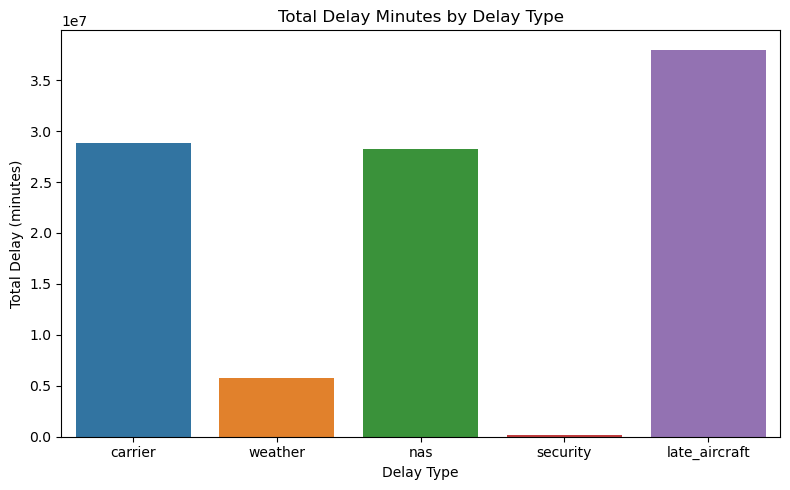

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(x='delay_name', y='total_delay_min', data=df, hue='delay_name')
plt.title('Total Delay Minutes by Delay Type')
plt.ylabel('Total Delay (minutes)')
plt.xlabel('Delay Type')
plt.tight_layout()
plt.show();

But when a delay does occur, on average, late aircraft and weather causes the most delay. Weather delays are rare but time-costly.

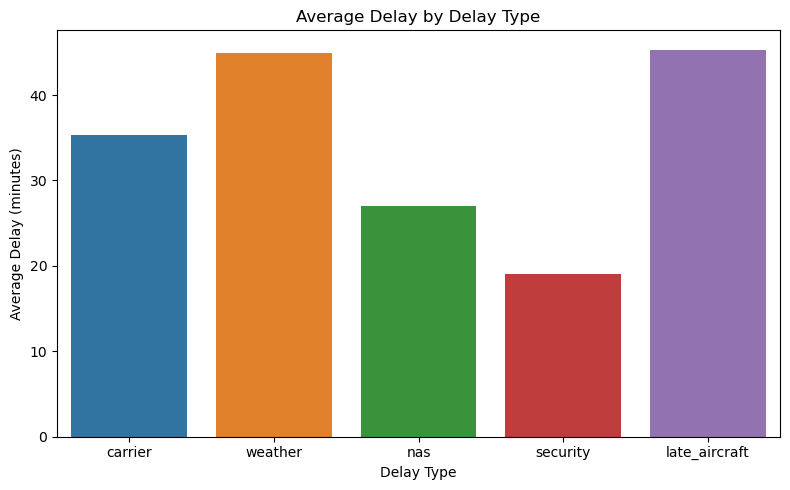

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(x='delay_name', y='avg_delay', data=df, hue='delay_name')
plt.title('Average Delay by Delay Type')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Delay Type')
plt.tight_layout()
plt.show()

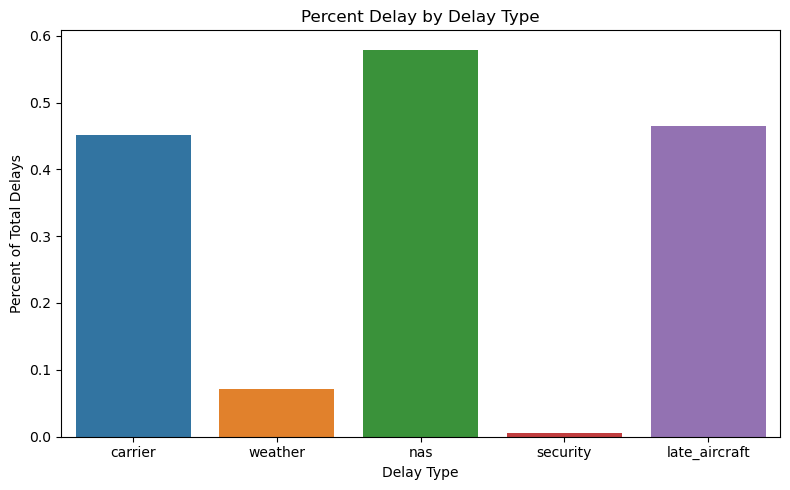

In [38]:
plt.figure(figsize=(8, 5))
sns.barplot(x='delay_name', y='percent_delay', data=df, hue='delay_name')
plt.title('Percent Delay by Delay Type')
plt.ylabel('Percent of Total Delays')
plt.xlabel('Delay Type')
plt.tight_layout()
plt.show()

Overall, NAS, carriers and late aircraft were the most common causes of delays. The least common causes was weather and security. However, when it came to average delay. If that delay actually occurred, weather caused the second most longest delay on average in minutes, with the first most longest delay on average being caused by late aircraft. In summary, if you had to be delayed, you'd prefer it to be by security, but not late aircraft since not only was it common, it'd delay you by the most. For the top three most common delays, you'd prefer it to be NAS delay since it only cause a 27 minute delay on average compared to a 35 minute carrier delay.

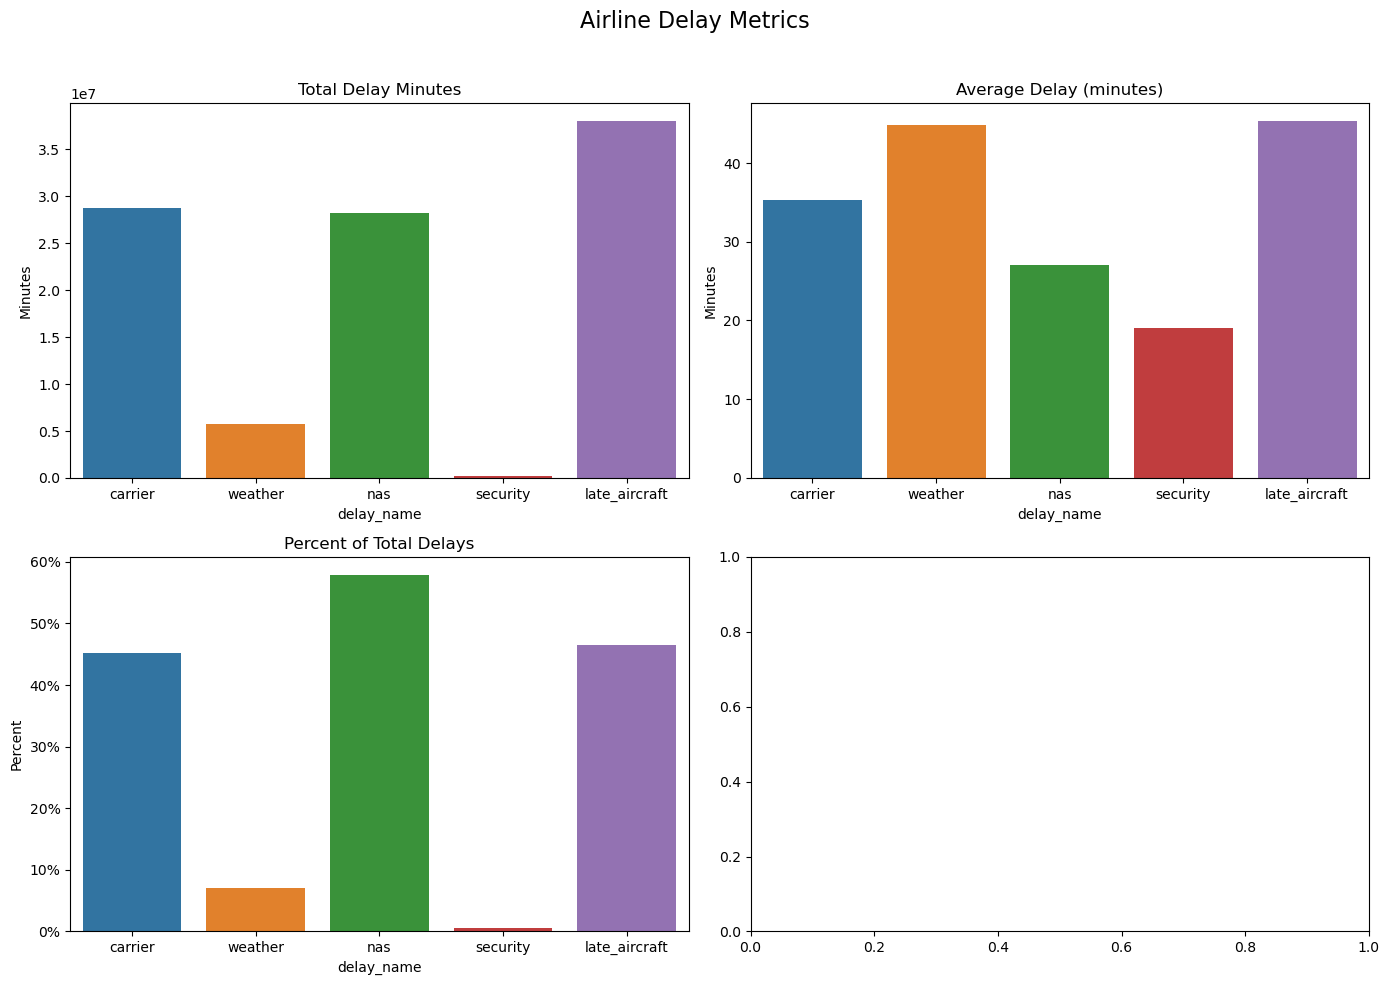

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Airline Delay Metrics', fontsize=16)

sns.barplot(ax=axs[0, 0], x='delay_name', y='total_delay_min', data=df, hue='delay_name')
axs[0, 0].set_title('Total Delay Minutes')
axs[0, 0].set_ylabel('Minutes')

sns.barplot(ax=axs[0, 1], x='delay_name', y='avg_delay', data=df, hue='delay_name')
axs[0, 1].set_title('Average Delay (minutes)')
axs[0, 1].set_ylabel('Minutes')

sns.barplot(ax=axs[1, 0], x='delay_name', y='percent_delay', data=df, hue='delay_name')
axs[1, 0].set_title('Percent of Total Delays')
axs[1, 0].set_ylabel('Percent')
axs[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()

In [50]:
cursor.execute("""SELECT CarrierDelay,  WeatherDelay,  NASDelay,  SecurityDelay , LateAircraftDelay
FROM year_2007
WHERE
  (CASE WHEN CarrierDelay != 0 THEN 1 ELSE 0 END
 + CASE WHEN WeatherDelay != 0 THEN 1 ELSE 0 END
 + CASE WHEN NASDelay != 0 THEN 1 ELSE 0 END
 + CASE WHEN SecurityDelay != 0 THEN 1 ELSE 0 END
 + CASE WHEN LateAircraftDelay != 0 THEN 1 ELSE 0 END
) >= 2""")
df = to_pd(cursor)

In [51]:
df.iloc[:,0]

0          3
1         23
2         46
3         20
4         49
          ..
868935     9
868936     0
868937     0
868938     0
868939    24
Name: carrierdelay, Length: 868940, dtype: int64

In [58]:
df2 = df.copy()
for col in range(5):
    df2.iloc[:,col] = df2.iloc[:, col].apply(lambda x: 1 if x != 0 else 0)
df2cvb

,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,0,0,1
4,1,0,0,0,1
...,...,...,...,...,...
868935,1,0,1,0,1
868936,0,0,1,0,1
868937,0,1,1,0,0
868938,0,0,1,0,1


NASDelays had the most co-occuring delays, meaning that whenever there was an issue with the weather carrier, late aircraft, security, NAS also got involved.

In [59]:
df2 = df2.T.dot(df2)
np.fill_diagonal(df2.values, 0)
df2

,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
carrierdelay,0,5051,358110,228,303940
weatherdelay,5051,0,72073,19,54857
nasdelay,358110,72073,0,4615,392255
securitydelay,228,19,4615,0,3936
lateaircraftdelay,303940,54857,392255,3936,0


In [66]:
tot=df2.sum(axis=0)
jacc_sim=pd.DataFrame(0,index=df2.columns, columns=df2.columns)
for col1 in df2.columns:
    for col2 in df2.columns:
        intersection = df2.loc[col1, col2]
        union = tot[col1] + tot[col2] - intersection
        if union > 0:
            jacc_sim.loc[col1, col2] = intersection / union
        else:
            jacc_sim.loc[col1, col2] = 0.0

In [67]:
jacc_sim

,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
carrierdelay,0.000000,0.006359,0.315162,0.000337,0.271769
weatherdelay,0.006359,0.000000,0.081257,0.000135,0.065924
nasdelay,0.315162,0.081257,0.000000,0.005552,0.329685
securitydelay,0.000337,0.000135,0.005552,0.000000,0.005180
lateaircraftdelay,0.271769,0.065924,0.329685,0.005180,0.000000


When looking at how much they co-occur relatively (using Jaccard's Similarity), when a co-occurence does happen, it's carrier, late aircraft and nas delay together or in pairs, this could be the reason why these three also had a higher occurance and impact when looking at it overall before this.

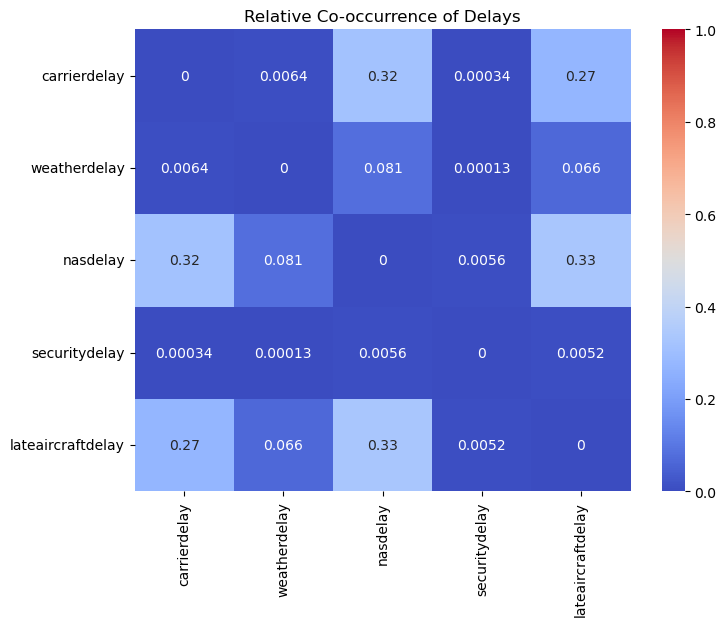

In [68]:

plt.figure(figsize=(8, 6))
sns.heatmap(jacc_sim, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Relative Co-occurrence of Delays")
plt.show()

## Cancellation Analysis

A is carrier, B is weather, C is NAS, D is security.

Out of 7453215 flights, 7292466 were not cancelled; 160749 flights were cancelled.

In [70]:
cursor.execute("""SELECT
  CancellationCode,
  COUNT(*) AS count
FROM year_2007
GROUP BY CancellationCode""")
cursor.fetchall()

[(None, 7292466), ('A', 66779), ('B', 61936), ('C', 31995), ('D', 39)]

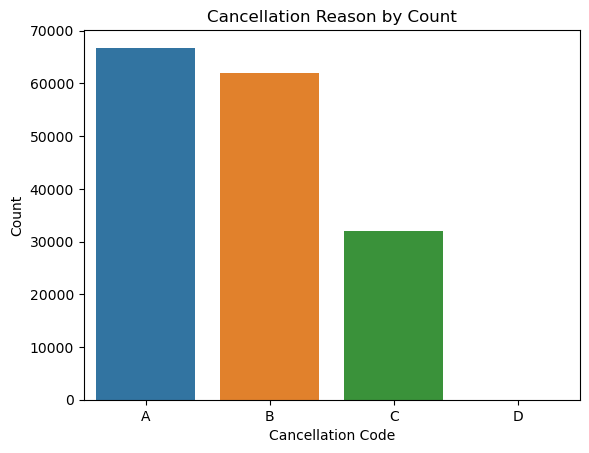

In [41]:

cancel = pd.DataFrame({
    'code':['A', 'B', 'C', 'D'],
    'count':[66779, 61936, 31995, 39]}) 
sns.barplot(x='code', y='count', data=cancel, hue='code')
plt.title('Cancellation Reason by Count')
plt.ylabel('Count')
plt.xlabel('Cancellation Code');

### Cancellations: all

In [43]:
def to_pd(cursor, batch_size=1000):
    columns = [desc[0] for desc in cursor.description]
    all_data = []
    while True:
        batch = cursor.fetchmany(batch_size)
        if not batch:
            break
        all_data.extend(batch)
    return pd.DataFrame(all_data, columns=columns)

In [ ]:
cursor.execute("""
SELECT
y.Cancelled,
y.cancellationcode,
ao.airport AS origin_airport,
ad.airport AS dest_airport,
c.description AS carrier_name
FROM year_2007 y
JOIN airports ao ON y.origin = ao.iata
JOIN airports ad ON y.dest = ad.iata
JOIN carriers c ON y.uniquecarrier = c.code
""")
all_cancel_df = to_pd(cursor)

In [ ]:
all_cancel_df = pd.read_csv(

In [9]:
cancel_df = all_cancel_df[all_cancel_df['y.cancelled'] == 1]
cancel_df

,y.cancelled,y.cancellationcode,origin_airport,dest_airport,carrier_name
38,1,A,John Wayne /Orange Co,McCarran International,Southwest Airlines Co.
325,1,A,Austin-Bergstrom International,Dallas Love,Southwest Airlines Co.
828,1,A,Dallas Love,Austin-Bergstrom International,Southwest Airlines Co.
847,1,A,Dallas Love,William P Hobby,Southwest Airlines Co.
851,1,A,Dallas Love,William P Hobby,Southwest Airlines Co.
...,...,...,...,...,...
7453123,1,B,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.
7453124,1,B,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7453130,1,B,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7453131,1,B,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.


In absolute numbers, American Eagle Airlines Inc.(22792), American Airlines Inc. (17924), Skywest Airlines Inc. (14186), United Air Lines Inc.(11929), Mesa Airlines Inc. (11287) are the top five airlines with the most cancelled flights by pure numbers.

However, when looking at it as a percentage of total flights, the airlines most likely to cancel are American Eagle Airlines Inc. (4.22%), Mesa Airlines Inc (3.834%), Comair Inc (3.786%), Atlantic Southeast Airlines (3.116%), Pinnacle Airlines Inc (3.067%). The highest has 4% of all its flights in 2007 be cancelled.ncelled.

carrier_name
American Eagle Airlines Inc.                                                           22792
American Airlines Inc.                                                                 17924
Skywest Airlines Inc.                                                                  14186
United Air Lines Inc.                                                                  11929
Mesa Airlines Inc.                                                                     11287
Expressjet Airlines Inc.                                                               10800
Southwest Airlines Co.                                                                  9993
US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)     8942
Atlantic Southeast Airlines                                                             8920
Comair Inc.                                                                             8851
Pinnacle Airlines Inc.                                   

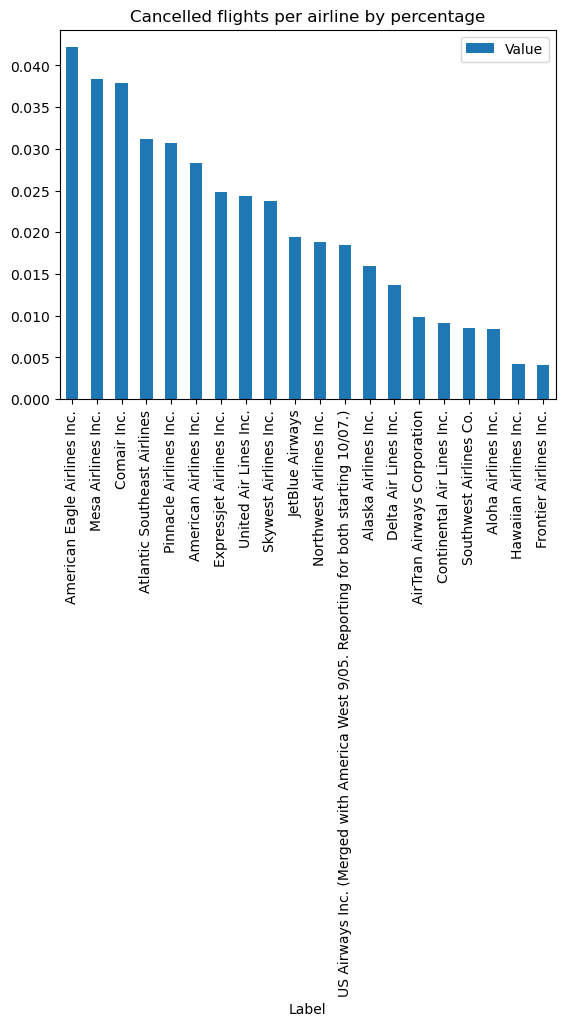

In [19]:
all_cancel = cancel_df['carrier_name'].value_counts()
all_airline = all_cancel_df['carrier_name'].value_counts()
all_rate = (all_cancel/all_airline).sort_values(ascending=False)
all_rate_df= all_rate.reset_index()
all_rate_df.columns=['Label','Value']
print(all_cancel)
print(all_rate)

all_rate_df.plot(x='Label', y='Value', kind='bar', title='Cancelled flights per airline by percentage');

On the other hand, Telluride Regional, Nantucket Memorial, Waterloo Municipal are the top three locations where your flight will be cancelled, with the top one having about a 15% chance. This is extremely high and it's only because there are only a few total flights for these locations so it could that it's because any cancelled flights has a big effect on percentage cancelled.

In [14]:
cancel_df['origin_airport'].value_counts()

origin_airport
Chicago O'Hare International           16615
Dallas-Fort Worth International         9372
William B Hartsfield-Atlanta Intl       6795
LaGuardia                               6413
Newark Intl                             5926
                                       ...  
Lewiston-Nez Perce County                  2
Gustavus                                   2
Greenbrier Valley                          1
Kinston Regional Jetport At Stallin        1
Roswell Industrial Air Center              1
Name: count, Length: 301, dtype: int64

origin_airport
Chicago O'Hare International           16615
Dallas-Fort Worth International         9372
William B Hartsfield-Atlanta Intl       6795
LaGuardia                               6413
Newark Intl                             5926
                                       ...  
Lewiston-Nez Perce County                  2
Gustavus                                   2
Greenbrier Valley                          1
Kinston Regional Jetport At Stallin        1
Roswell Industrial Air Center              1
Name: count, Length: 301, dtype: int64
origin_airport
William B Hartsfield-Atlanta Intl      413851
Chicago O'Hare International           375784
Dallas-Fort Worth International        297345
Denver Intl                            240928
Los Angeles International              237597
                                        ...  
Chippewa Valley Regional                   72
Kinston Regional Jetport At Stallin         9
Pierre Regional                             4
Mid Delta Regional    

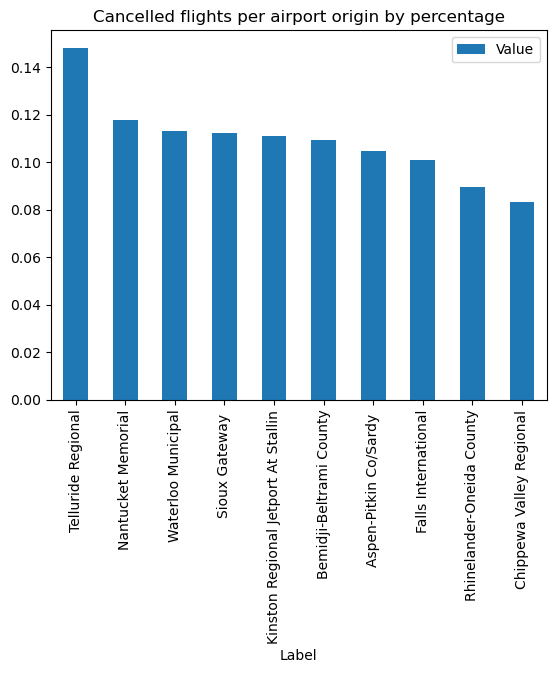

In [21]:
all_cancel = cancel_df['origin_airport'].value_counts()
all_airline = all_cancel_df['origin_airport'].value_counts()
all_rate = (all_cancel/all_airline).sort_values(ascending=False)
all_rate_df= all_rate.reset_index()
all_rate_df.columns=['Label','Value']
print(all_cancel)
print(all_airline)
print(all_rate)

all_rate_df.head(10).plot(x='Label', y='Value', kind='bar', title='Cancelled flights per airport origin by percentage');

For airports that had at least 1000 outgoing flights recorded for 2007, the worst airports for if you want to avoid a cancelled flight is Aspen-Pitkin Co/Sardy (10.480679%), Capital (7.679083%), Kalamazoo County (7.322789%), Sheppard AFB/Wichita Falls Municipal (6.908463%), Rochester International (6.773283%).

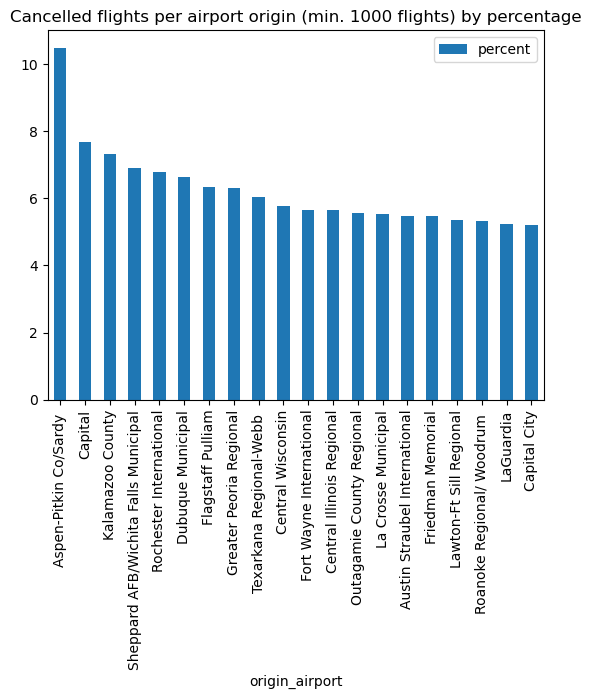

In [36]:
filter = all_airline[all_airline >= 1000].index

fil_tot = all_airline[filter]
fil_canc = all_cancel.reindex(filter, fill_value=0)

pp = (fil_canc / fil_tot) * 100

dfdf = pd.DataFrame({
    'total_flights': fil_tot,
    'cancelled_flights': fil_canc,
    'percent': pp
})

dfdf = dfdf.sort_values(by='percent', ascending=False)

dfdf.head(20).reset_index().plot(x = 'origin_airport', y='percent', kind='bar', title='Cancelled flights per airport origin (min. 1000 flights) by percentage');

In [31]:
dfdf

,total_flights,cancelled_flights,percent
origin_airport,,,
Aspen-Pitkin Co/Sardy,5305,556,10.480679
Capital,1745,134,7.679083
Kalamazoo County,5121,375,7.322789
Sheppard AFB/Wichita Falls Municipal,2316,160,6.908463
Rochester International,4252,288,6.773283
...,...,...,...
Pocatello Regional,1824,11,0.603070
Honolulu International,67581,407,0.602240
Lihue,15677,89,0.567711


Do you want to fly somewhere? Well, if you're flying to these locations, you'll have to know that a certain percentage of flights going there have historically been cancelled. For airports that had at least 1000 incoming flights recorded for 2007, the worst airports for if you want to avoid a cancelled flight is Aspen-Pitkin Co/Sardy (9.219% of flights were cancelled), Kalamazoo County (6.8128%), Capital (6.659%), Rochester International (6.373471%), 
Dubuque Municipa (	6.16147%). As you can see, Aspen, Kalamazoo, Capital, Rochester are airports that have a lot of cancellations for any sort of flight coming in or out by percent of total flights.3

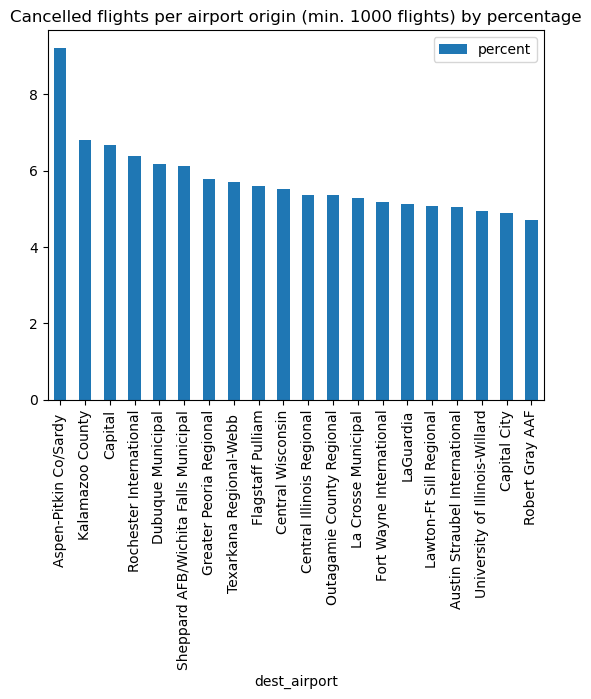

In [41]:
all_cancel = cancel_df['dest_airport'].value_counts()
all_airline = all_cancel_df['dest_airport'].value_counts()

filter = all_airline[all_airline >= 1000].index

fil_tot = all_airline[filter]
fil_canc = all_cancel.reindex(filter, fill_value=0)

pp = (fil_canc / fil_tot) * 100

dfdf_dest = pd.DataFrame({
    'total_flights': fil_tot,
    'cancelled_flights': fil_canc,
    'percent': pp
})

dfdf_dest = dfdf_dest.sort_values(by='percent', ascending=False)

dfdf_dest.head(20).reset_index().plot(x = 'dest_airport', y='percent', kind='bar', title='Cancelled flights per airport origin (min. 1000 flights) by percentage');

In [42]:
dfdf_dest

,total_flights,cancelled_flights,percent
dest_airport,,,
Aspen-Pitkin Co/Sardy,5250,484,9.219048
Kalamazoo County,5108,348,6.812843
Capital,1742,116,6.659013
Rochester International,4252,271,6.373471
Dubuque Municipal,1412,87,6.161473
...,...,...,...
Lihue,15676,72,0.459301
St George Muni,3630,14,0.385675
Roberts,3646,12,0.329128


In [50]:
cursor.execute("""
SELECT 
Month,
COUNT(*) AS total_flights
FROM year_2007
GROUP BY Month
ORDER BY Month""")
cursor.fetchall()

[(1, 621559),
 (2, 565604),
 (3, 639209),
 (4, 614648),
 (5, 631609),
 (6, 629280),
 (7, 648560),
 (8, 653279),
 (9, 600187),
 (10, 629992),
 (11, 605149),
 (12, 614139)]

In [52]:
cursor.execute("""
SELECT 
    Month,
    COUNT(*) AS cancelled_flights
FROM 
    year_2007
WHERE 
    Cancelled = 1
GROUP BY 
    Month
ORDER BY 
    Month""")
cancel_month = to_pd(cursor)

In [53]:
cancel_month

,month,cancelled_flights
0,1,15777
1,2,25465
2,3,16877
3,4,11138
4,5,6841
5,6,17243
6,7,13506
7,8,12295
8,9,6507
9,10,7327


Feb and Dec the worst months to get a flight in, possibly due to storms.

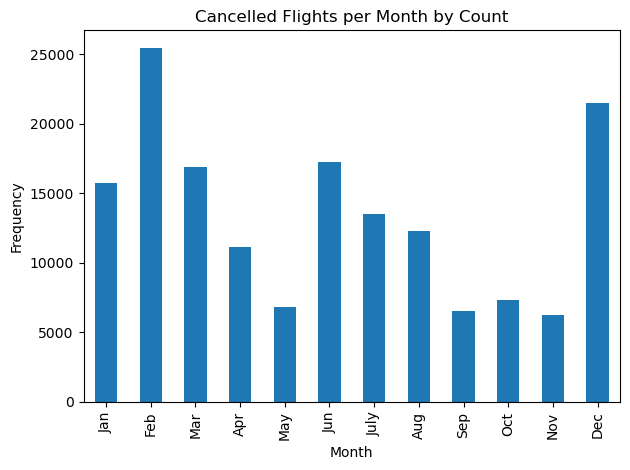

In [55]:
cancel_month['month_label']=['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']

cancel_month.plot(x='month_label', y='cancelled_flights', kind='bar', legend=False)
plt.title('Cancelled Flights per Month by Count')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Cancellation Code: A (carrier)

In [56]:
cancel_df

,y.cancelled,y.cancellationcode,origin_airport,dest_airport,carrier_name
38,1,A,John Wayne /Orange Co,McCarran International,Southwest Airlines Co.
325,1,A,Austin-Bergstrom International,Dallas Love,Southwest Airlines Co.
828,1,A,Dallas Love,Austin-Bergstrom International,Southwest Airlines Co.
847,1,A,Dallas Love,William P Hobby,Southwest Airlines Co.
851,1,A,Dallas Love,William P Hobby,Southwest Airlines Co.
...,...,...,...,...,...
7453123,1,B,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.
7453124,1,B,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7453130,1,B,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7453131,1,B,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.


In [58]:
AA = cancel_df[cancel_df['y.cancellationcode'] == 'A']
AA

,y.cancelled,y.cancellationcode,origin_airport,dest_airport,carrier_name
38,1,A,John Wayne /Orange Co,McCarran International,Southwest Airlines Co.
325,1,A,Austin-Bergstrom International,Dallas Love,Southwest Airlines Co.
828,1,A,Dallas Love,Austin-Bergstrom International,Southwest Airlines Co.
847,1,A,Dallas Love,William P Hobby,Southwest Airlines Co.
851,1,A,Dallas Love,William P Hobby,Southwest Airlines Co.
...,...,...,...,...,...
7452544,1,A,Cincinnati Northern Kentucky Intl,San Francisco International,Delta Air Lines Inc.
7452754,1,A,Mobile Regional,William B Hartsfield-Atlanta Intl,Delta Air Lines Inc.
7452884,1,A,William B Hartsfield-Atlanta Intl,Memphis International,Delta Air Lines Inc.
7452887,1,A,Memphis International,William B Hartsfield-Atlanta Intl,Delta Air Lines Inc.


Out of all cancelled flights that occurred, carrier cancellations was the cause of all or the majority of cancellation reasons for Aloha Airlines Inc. (1.0), Hawaiian Airlines Inc. (1.0), Alaska Airlines Inc. (0.853297), Pinnacle Airlines Inc. (0.663434) , US Airways Inc. (0.625587). 

Aloha Airlines was struggling financially in 2007 and filed for Chapter 11 bankruptcy protectionber 2004 and again in 2008. In 2007, its operations wemost likely re already unsta, so cancelling flights could have went up due to lack of crew and financial instability.e. . ssues.

                                                Label     Value
0                                 Aloha Airlines Inc.  1.000000
1                              Hawaiian Airlines Inc.  1.000000
2                                Alaska Airlines Inc.  0.853297
3                              Pinnacle Airlines Inc.  0.663434
4   US Airways Inc. (Merged with America West 9/05...  0.625587
5                             Northwest Airlines Inc.  0.620937
6                               United Air Lines Inc.  0.615978
7                              Southwest Airlines Co.  0.576403
8                         Atlantic Southeast Airlines  0.537780
9                              Frontier Airlines Inc.  0.507538
10                               Delta Air Lines Inc.  0.491796
11                        AirTran Airways Corporation  0.485780
12                                 Mesa Airlines Inc.  0.480287
13                                    JetBlue Airways  0.466846
14                              Skywest 

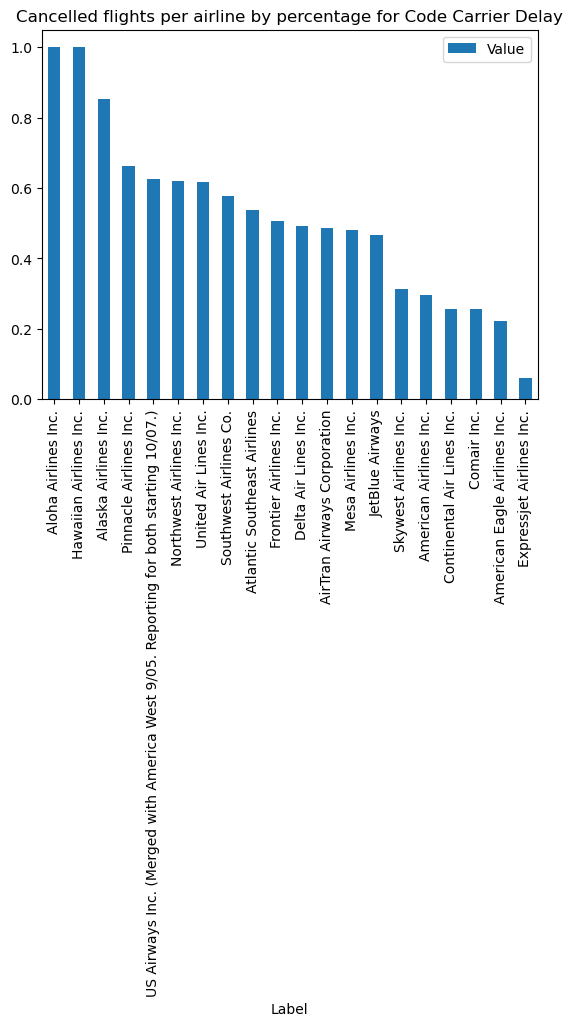

In [61]:
aa_airline = AA['carrier_name'].value_counts()
all_airline = cancel_df['carrier_name'].value_counts()
aa_rate = (aa_airline/all_airline).sort_values(ascending=False)
all_rate_df= aa_rate.reset_index()
all_rate_df.columns=['Label','Value']
print(all_rate_df)

all_rate_df.plot(x='Label', y='Value', kind='bar', title='Cancelled flights per airline by percentage for Code Carrier Delay');

### Cancellation Code: B (weather)

In [63]:
BB = cancel_df[cancel_df['y.cancellationcode'] == 'B']
BB

,y.cancelled,y.cancellationcode,origin_airport,dest_airport,carrier_name
7364,1,B,Dallas Love,William P Hobby,Southwest Airlines Co.
7426,1,B,Dallas Love,San Antonio International,Southwest Airlines Co.
7631,1,B,William P Hobby,Dallas Love,Southwest Airlines Co.
9466,1,B,San Antonio International,Dallas Love,Southwest Airlines Co.
9597,1,B,San Jose International,Ontario International,Southwest Airlines Co.
...,...,...,...,...,...
7453123,1,B,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.
7453124,1,B,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7453130,1,B,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7453131,1,B,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.


Out of all cancelled flights that occurred, weather cancellations was the cause of all or the majority of cancellation reasons for Adak (1.0), Roswell Industrial Air Center (1.0), McNary Fld (1.0), Bellingham Intl (0.8), Aspen-Pitkin Co/Sardy (0.793165).

Aspen-Pitkin Co/Sardy appears here again. It was the airport with the most cancellations overall, and it seems that 79% of them are caused by weather issues. The airport has a smaller airfield size (large planes cannot come here), and its location in a high elevation mountain valley. Possibly mountain weather like storms, wind shear, snow, along with its short runway and steep approach means the thresholds to cancel due to weather issues are probably stricter to.
[22]165

                                   Label     Value
0                                   Adak  1.000000
1          Roswell Industrial Air Center  1.000000
2                             McNary Fld  1.000000
3                        Bellingham Intl  0.800000
4                 Aspen-Pitkin Co/Sardy   0.793165
..                                   ...       ...
296                   Hilo International       NaN
297  Kinston Regional Jetport At Stallin       NaN
298        Kona International At Keahole       NaN
299            Lewiston-Nez Perce County       NaN
300                                Lihue       NaN

[301 rows x 2 columns]


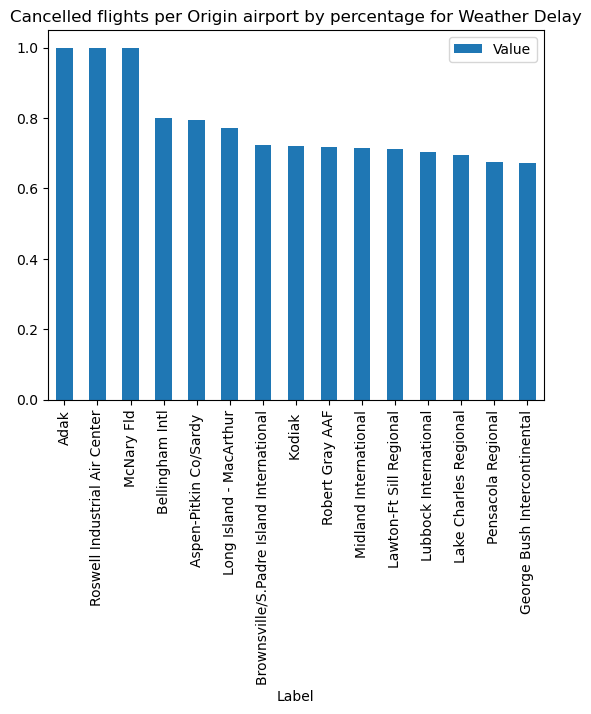

In [66]:
aa_airline = BB['origin_airport'].value_counts()
all_airline = cancel_df['origin_airport'].value_counts()
aa_rate = (aa_airline/all_airline).sort_values(ascending=False)
all_rate_df= aa_rate.reset_index()
all_rate_df.columns=['Label','Value']
print(all_rate_df)

all_rate_df.head(15).plot(x='Label', y='Value', kind='bar', title='Cancelled flights per Origin airport by percentage for Weather Delay');

Usually, a flight is cancelled before it takes off, so the origin airport has mort of an impact than the destination airport, but for the destination airports that have high cancellation ratios, all of them are also in the 15 most cancelled origin airports except for Florida Keys, Yakima Air Terminal, Santa Maria Pub/Capt G Allan Hancock, and Sitka. 

                             Label  Value
0    Roswell Industrial Air Center    1.0
1                       McNary Fld    1.0
2            Florida Keys Marathon    1.0
3              Yakima Air Terminal    1.0
4                  Bellingham Intl    1.0
..                             ...    ...
295                          Lihue    NaN
296        Middle Georgia Regional    NaN
297                   Moore County    NaN
298     Palmdale Production Flight    NaN
299                    Yellowstone    NaN

[300 rows x 2 columns]


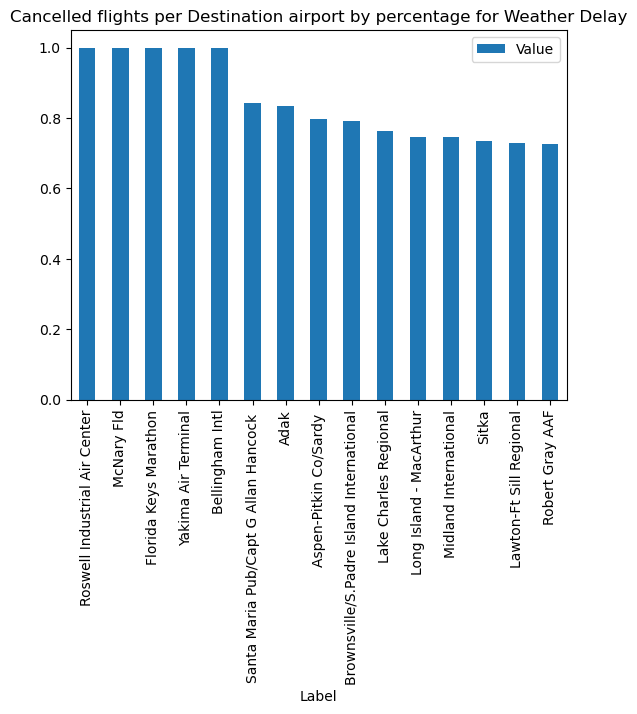

In [67]:
aa_airline = BB['dest_airport'].value_counts()
all_airline = cancel_df['dest_airport'].value_counts()
aa_rate = (aa_airline/all_airline).sort_values(ascending=False)
all_rate_df= aa_rate.reset_index()
all_rate_df.columns=['Label','Value']
print(all_rate_df)


all_rate_df.head(15).plot(x='Label', y='Value', kind='bar', title='Cancelled flights per Destination airport by percentage for Weather Delay');

The worst when it comes to weather delays occurs during the Winter season especially in February (2.8% of flights) and December (1.8%) of flights have to get cancelled due to weather reasons. Potentially due to heavy snow or ice storms which could affect visibilityand maneuverability of plane. 

In [69]:
cursor.execute("""
SELECT Month,
    COUNT(*) AS cancelled_flights
FROM year_2007
WHERE Cancelled = 1 AND CancellationCode = 'B'
GROUP BY Month
ORDER BY Month
""")
cancel_month = to_pd(cursor)

In [70]:
cancel_month

,month,cancelled_flights
0,1,8253
1,2,15872
2,3,8245
3,4,3419
4,5,1690
5,6,4059
6,7,3193
7,8,2091
8,9,1049
9,10,1675


In [ ]:
cursor.execute("""
SELECT 
Month,
COUNT(*) AS count
FROM year_2007
WHERE CancellationCode != 'B'
GROUP BY Month
ORDER BY Month
""")
cancel_month_all = to_pd(cursor)

The worst months for potential flight cancellations due to weather is during the winter months especially February and December.

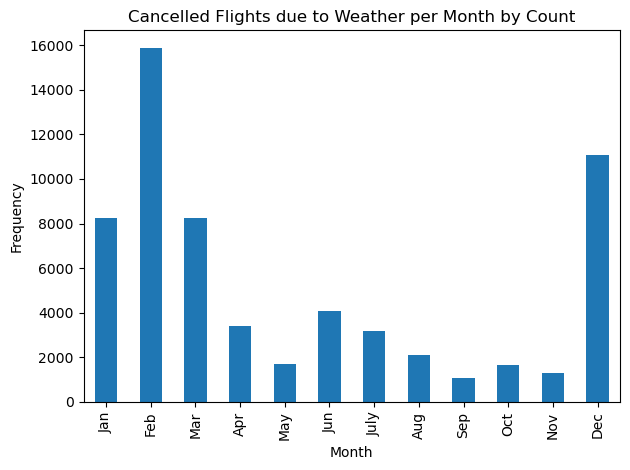

In [71]:
cancel_month['month_label']=['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']

cancel_month.plot(x='month_label', y='cancelled_flights', kind='bar', legend=False)
plt.title('Cancelled Flights due to Weather per Month by Count')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Cancellation Code C: NAS

NAS cancellations occur when there is an issue with the National Air Service, like ATC delays, equipment outages, ground stops, or crowded airspace. Since cancellations occur before flight, I'll focus on origin airport and time factors.

In [72]:
CC = cancel_df[cancel_df['y.cancellationcode'] == 'C']
CC

,y.cancelled,y.cancellationcode,origin_airport,dest_airport,carrier_name
8131,1,C,Los Angeles International,Phoenix Sky Harbor International,Southwest Airlines Co.
9176,1,C,Phoenix Sky Harbor International,San Diego International-Lindbergh,Southwest Airlines Co.
9444,1,C,San Diego International-Lindbergh,Sacramento International,Southwest Airlines Co.
11613,1,C,Orlando International,Philadelphia Intl,Southwest Airlines Co.
11793,1,C,Chicago Midway,Philadelphia Intl,Southwest Airlines Co.
...,...,...,...,...,...
7450387,1,C,Gen Edw L Logan Intl,LaGuardia,Delta Air Lines Inc.
7450392,1,C,LaGuardia,Gen Edw L Logan Intl,Delta Air Lines Inc.
7450417,1,C,Ronald Reagan Washington National,LaGuardia,Delta Air Lines Inc.
7450418,1,C,LaGuardia,Ronald Reagan Washington National,Delta Air Lines Inc.


For all cancelled flights, Chico Municipal (60.0%), Newark Intl (48.48%), Capital (47.76%), Modesto City-County-Harry Sham (43.27%), Greater Peoria Regional (42.69%) had the highest percentage of cancellations being due to NAS.

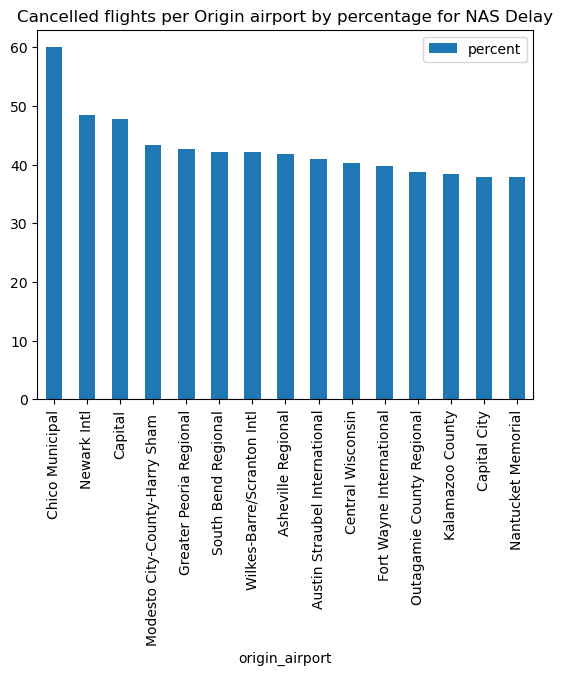

In [82]:
aa_airline = CC['origin_airport'].value_counts()
all_airline = cancel_df['origin_airport'].value_counts()

filter = aa_airline[aa_airline >= 10].index

fil_tot = all_airline.reindex(filter, fill_value=0)
fil_canc = aa_airline[filter]

pp = (fil_canc / fil_tot) * 100

dfdf_cc = pd.DataFrame({
    'total_flights': fil_tot,
    'cancelled_flights': fil_canc,
    'percent': pp
})
dfdf_cc = dfdf_cc.sort_values(by='percent', ascending=False)

dfdf_cc.head(15).reset_index().plot(x='origin_airport', y='percent', kind='bar', title='Cancelled flights per Origin airport by percentage for NAS Delay');

In [95]:
print(dfdf_cc.iloc[0:10,-1:].round(2).astype(str) + '%')

                                percent
origin_airport                         
Chico Municipal                   60.0%
Newark Intl                      48.48%
Capital                          47.76%
Modesto City-County-Harry Sham   43.27%
Greater Peoria Regional          42.69%
South Bend Regional              42.13%
Wilkes-Barre/Scranton Intl       42.11%
Asheville Regional                41.8%
Austin Straubel International     41.0%
Central Wisconsin                 40.2%


In [83]:
dfdf_cc

,total_flights,cancelled_flights,percent
origin_airport,,,
Chico Municipal,45,27,60.000000
Newark Intl,5926,2873,48.481269
Capital,134,64,47.761194
Modesto City-County-Harry Sham,104,45,43.269231
Greater Peoria Regional,342,146,42.690058
...,...,...,...
Aspen-Pitkin Co/Sardy,556,24,4.316547
Salt Lake City Intl,1123,44,3.918077
Portland Intl,442,16,3.619910


In [99]:
cursor.execute("""
SELECT
  CASE 
    WHEN crsdeptime >= 0 AND crsdeptime < 1200 THEN 'Morning'
    WHEN crsdeptime >= 1200 AND crsdeptime < 1700 THEN 'Afternoon'
    WHEN crsdeptime >= 1700 AND crsdeptime <= 2400 THEN 'Evening'
  END AS time_of_day,
  COUNT(*) AS cancelled_flights
FROM
  year_2007
WHERE
  CancellationCode = 'C'
GROUP BY
  CASE 
    WHEN crsdeptime >= 0 AND crsdeptime < 1200 THEN 'Morning'
    WHEN crsdeptime >= 1200 AND crsdeptime < 1700 THEN 'Afternoon'
    WHEN crsdeptime >= 1700 AND crsdeptime <= 2400 THEN 'Evening'
  END
ORDER BY
  time_of_day
""")
cancel_month_all = to_pd(cursor)

In [110]:
cancel_month_all

,time_of_day,cancelled_flights
0,Afternoon,11724
1,Evening,14631
2,Morning,5640


Similar to the pattern seen in average delays, cancellations are most frequent in the evenings, while mornings from 00:00 to 11:59 have less cancelled flights.

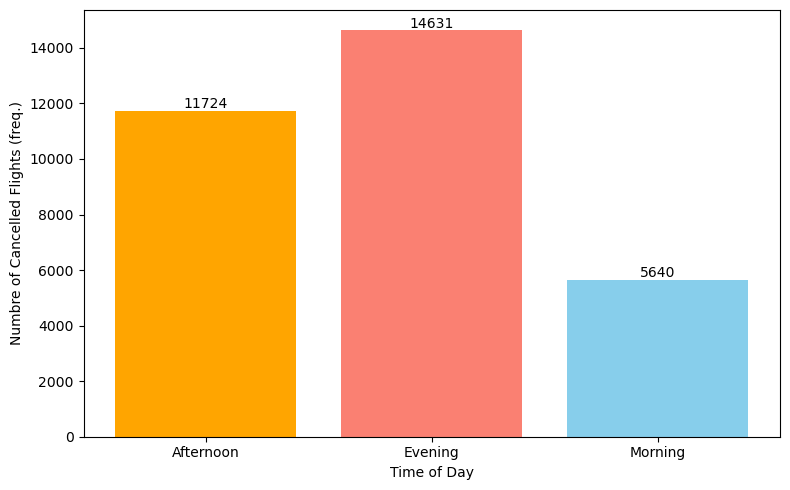

In [109]:
plt.figure(figsize=(8, 5))
plt.bar(cancel_month_all['time_of_day'], cancel_month_all['cancelled_flights'], color=['orange', 'salmon', 'skyblue'])
plt.xlabel('Time of Day')
plt.ylabel('Numbre of Cancelled Flights (freq.)')
for i, value in enumerate(cancel_month_all['cancelled_flights']):
    plt.text(i, value + 100, value, ha='center')

plt.tight_layout()
plt.show()

In [116]:
cursor.execute("""
SELECT
  dayofweek,
  COUNT(*) AS cancelled_flights
FROM
  year_2007
WHERE
  CancellationCode = 'C'
GROUP BY
  dayofweek
ORDER BY
  dayofweek""")
cc_week = to_pd(cursor)
cc_week

,dayofweek,cancelled_flights
0,1,4346
1,2,5404
2,3,6114
3,4,6634
4,5,5281
5,6,1348
6,7,2868


Flights can cancelled due to NAS most often during the weekday (culminating in Thursday) before it drops, where compared to the weekdays, the weekend has less cancelled flights.

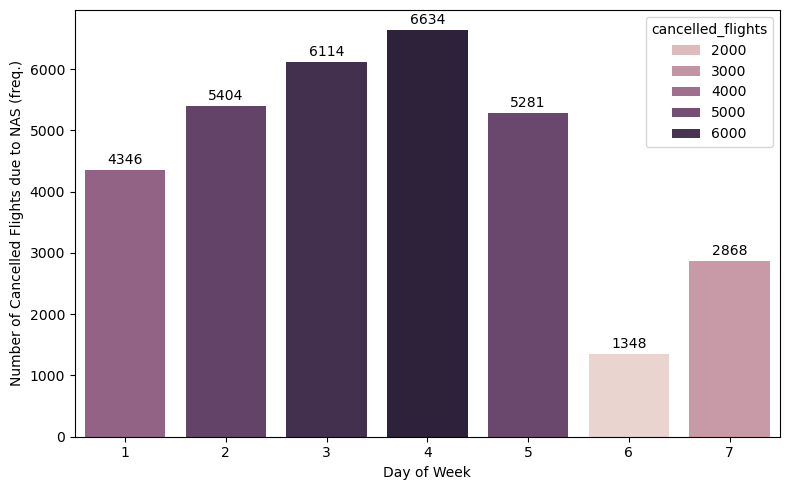

In [119]:
plt.figure(figsize=(8, 5))
sns.barplot(x='dayofweek', y='cancelled_flights', data=cc_week, hue='cancelled_flights')
plt.xlabel('Day of Week')
plt.ylabel('Number of Cancelled Flights due to NAS (freq.)')
for i, value in enumerate(cc_week['cancelled_flights']):
    plt.text(i, value + 100, value, ha='center')

plt.tight_layout()
plt.show()

## Problematic Routes

In [136]:
cursor.execute("""
SELECT
  a1.airport AS origin_airport,
  a2.airport AS dest_airport,
  f.Origin,
  f.Dest,
  f.FlightNum,
  f.total_flights,
  f.cancelled_flights,
  f.total_delay_minutes
FROM (
  SELECT
    Origin,
    Dest,
    FlightNum,
    COUNT(*) AS total_flights,
    SUM(Cancelled) AS cancelled_flights,
    SUM(CarrierDelay + NASDelay + WeatherDelay + SecurityDelay + LateAircraftDelay) AS total_delay_minutes
  FROM year_2007
  GROUP BY Origin, Dest, FlightNum
  HAVING
    SUM(Cancelled) > 0
    OR
    SUM(CarrierDelay + NASDelay + WeatherDelay + SecurityDelay + LateAircraftDelay) > 0
) f
JOIN airports a1 ON f.Origin = a1.iata
JOIN airports a2 ON f.Dest = a2.iata
ORDER BY
  f.total_delay_minutes DESC,
  f.cancelled_flights DESC""")
probprob = to_pd(cursor)

In [137]:
probprob

,origin_airport,dest_airport,f.origin,f.dest,f.flightnum,f.total_flights,f.cancelled_flights,f.total_delay_minutes
0,Orlando International,Newark Intl,MCO,EWR,524,364,3,22924
1,Detroit Metropolitan-Wayne County,Newark Intl,DTW,EWR,3053,358,21,22508
2,Washington Dulles International,Newark Intl,IAD,EWR,1276,365,18,21566
3,Luis Munoz Marin International,Philadelphia Intl,SJU,PHL,1024,365,7,21078
4,Fort Lauderdale-Hollywood Int'l,Newark Intl,FLL,EWR,510,365,4,20977
...,...,...,...,...,...,...,...,...
81811,William B Hartsfield-Atlanta Intl,Des Moines International,ATL,DSM,4760,5,1,0
81812,Tampa International,Chicago Midway,TPA,MDW,798,8,1,0
81813,Tampa International,Chicago Midway,TPA,MDW,2325,8,1,0
81814,William B Hartsfield-Atlanta Intl,Detroit Metropolitan-Wayne County,ATL,DTW,4284,1,1,0


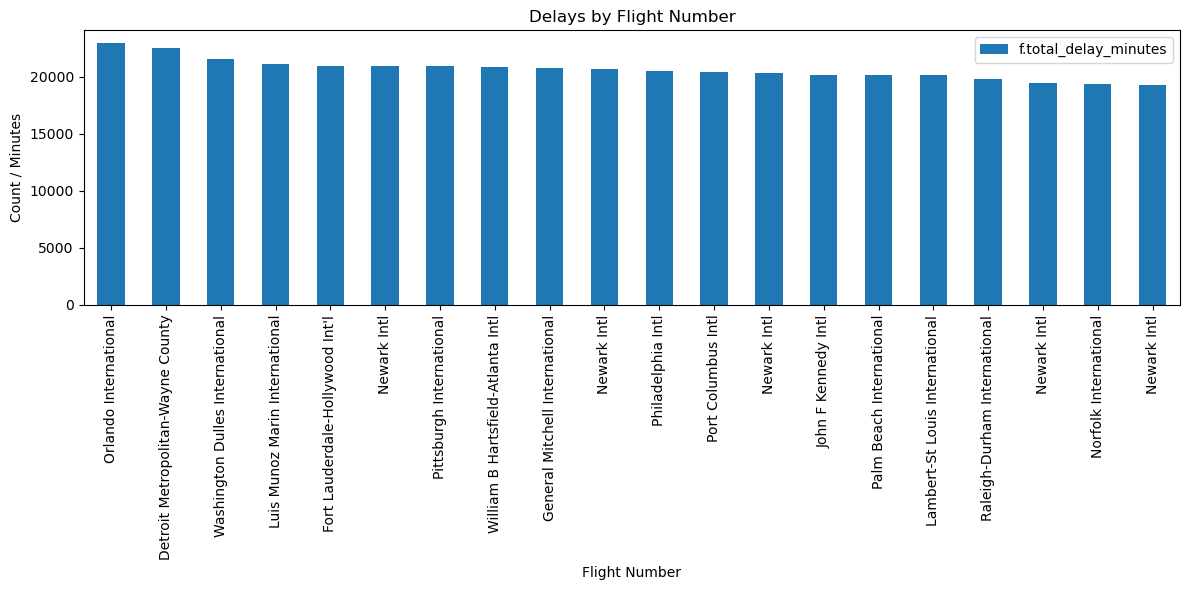

In [186]:
probprob = probprob.sort_values('f.total_delay_minutes', ascending=False)

probprob.head(20).plot(
    x='origin_airport',
    y=['f.total_delay_minutes'],
    kind='bar',
    figsize=(12, 6),
    title='Delays by Flight Number'
)
plt.xlabel('Flight Number')
plt.ylabel('Count / Minutes')
plt.tight_layout()
plt.show()

In [189]:
cursor.execute("""
SELECT
  FlightNum,
  COUNT(*) AS total_flights,
  SUM(Cancelled) AS cancelled_flights,
  SUM(CarrierDelay + NASDelay + WeatherDelay + SecurityDelay + LateAircraftDelay) AS total_delay_minutes
FROM year_2007
GROUP BY FlightNum
ORDER BY total_delay_minutes DESC, cancelled_flights DESC
""")
prob_flightnum = to_pd(cursor)

In [190]:
prob_flightnum

,flightnum,total_flights,cancelled_flights,total_delay_minutes
0,44,4584,42,80482
1,36,3583,43,79835
2,43,4656,59,76507
3,529,5048,122,76001
4,425,4560,68,75911
...,...,...,...,...
7591,3290,9,0,0
7592,3283,21,0,0
7593,7696,1,0,0
7594,8617,1,0,0


In [191]:
## adding percent
prob_flightnum['percent_cancel'] = (prob_flightnum['cancelled_flights'] / prob_flightnum['total_flights']) * 100
prob_flightnum['delay_per_flight'] = (prob_flightnum['total_delay_minutes'] / prob_flightnum['total_flights'])
prob_flightnum

,flightnum,total_flights,cancelled_flights,total_delay_minutes,percent_cancel,delay_per_flight
0,44,4584,42,80482,0.916230,17.557155
1,36,3583,43,79835,1.200112,22.281608
2,43,4656,59,76507,1.267182,16.431916
3,529,5048,122,76001,2.416799,15.055666
4,425,4560,68,75911,1.491228,16.647149
...,...,...,...,...,...,...
7591,3290,9,0,0,0.000000,0.000000
7592,3283,21,0,0,0.000000,0.000000
7593,7696,1,0,0,0.000000,0.000000
7594,8617,1,0,0,0.000000,0.000000


In [200]:
prob_flightnum = prob_flightnum.sort_values('delay_per_flight', ascending=False)
prob_flightnum_100 = prob_flightnum[prob_flightnum['total_flights'] >= 100]
prob_flightnum_100

,flightnum,total_flights,cancelled_flights,total_delay_minutes,percent_cancel,delay_per_flight
3602,6868,157,5,9310,3.184713,59.299363
4886,6950,112,4,6139,3.571429,54.812500
5238,6978,105,9,5436,8.571429,51.771429
1872,4954,358,48,17744,13.407821,49.564246
5462,7485,101,6,4957,5.940594,49.079208
...,...,...,...,...,...,...
7452,6233,153,1,220,0.653595,1.437908
7370,6523,364,3,501,0.824176,1.376374
7447,6111,171,0,228,0.000000,1.333333
7462,6242,157,0,162,0.000000,1.031847


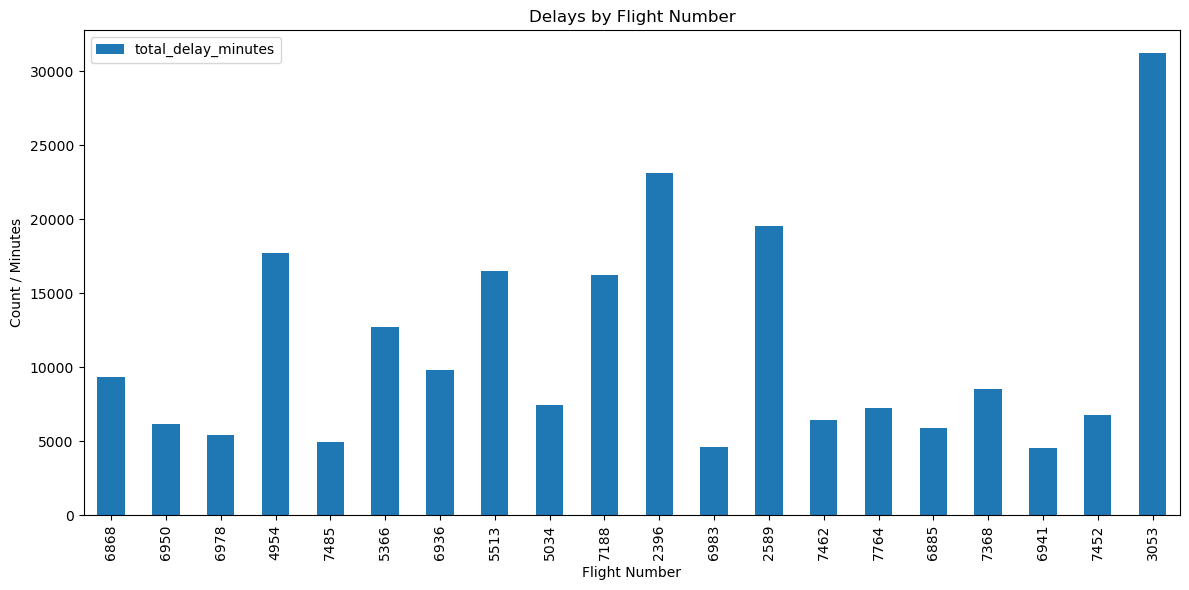

In [201]:
prob_flightnum_100 = prob_flightnum_100.sort_values('delay_per_flight', ascending=False)

prob_flightnum_100.head(20).plot(
    x='flightnum',
    y=['total_delay_minutes'],
    kind='bar',
    figsize=(12, 6),
    title='Delays by Flight Number'
)
plt.xlabel('Flight Number')
plt.ylabel('Count / Minutes')
plt.tight_layout()
plt.show()

Out of all the flights that had some cancel or delay with at least 100 total flights, a few flight numbers stand out. Flight number 6868, 6950, 6978 had the highest delay on average with about 50 to 60 minutes of delay per flight. For cancelled flights, flight number 6906 had to cancel just under 30% of all flights in 2007. Overall, there is a slight inverse relationship going on with delay and cancelled flights, with none in the top right qudrant of the graph. The flights with bad delay and relatively higher cancelled flights by percent is 4954 ot 3074 with an average of 40 minutes of delay and more than 12-15% of their flights cancelled.

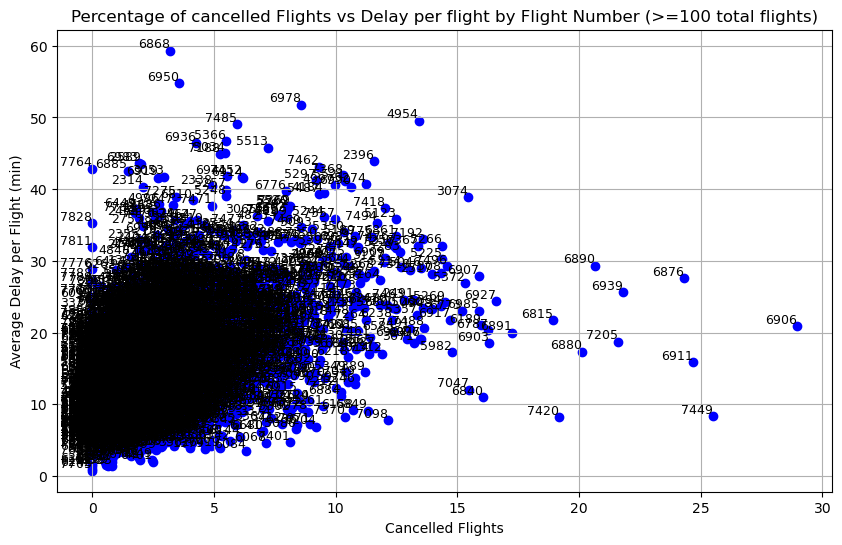

In [203]:
plt.figure(figsize=(10, 6))
plt.scatter(prob_flightnum_100['percent_cancel'], prob_flightnum_100['delay_per_flight'], color='blue')

for i, flight in prob_flightnum_100.iterrows():
    plt.text(flight['percent_cancel'], flight['delay_per_flight'], str(flight['flightnum']),
             fontsize=9, ha='right', va='bottom')

plt.xlabel('Cancelled Flights')
plt.ylabel('Average Delay per Flight (min)')
plt.title('Percentage of cancelled Flights vs Delay per flight by Flight Number (>=100 total flights)')
plt.grid(True)
plt.show()

In [197]:
cursor.execute("""
SELECT
  a1.airport AS origin_airport,
  a2.airport AS dest_airport,
  f.Origin,
  f.Dest,
  f.total_flights,
  f.cancelled_flights,
  f.total_delay_minutes
FROM (
  SELECT
    Origin,
    Dest,
    COUNT(*) AS total_flights,
    SUM(Cancelled) AS cancelled_flights,
    SUM(CarrierDelay + NASDelay + WeatherDelay + SecurityDelay + LateAircraftDelay) AS total_delay_minutes
  FROM year_2007
  GROUP BY Origin, Dest
) f
JOIN airports a1 ON f.Origin = a1.iata
JOIN airports a2 ON f.Dest = a2.iata
ORDER BY
  f.total_delay_minutes DESC,
  f.cancelled_flights DESC""")
prob_origindest = to_pd(cursor)

In [155]:
prob_origindest

,origin_airport,dest_airport,f.origin,f.dest,f.total_flights,f.cancelled_flights,f.total_delay_minutes
0,Chicago O'Hare International,LaGuardia,ORD,LGA,11337,855,287528
1,LaGuardia,Chicago O'Hare International,LGA,ORD,11333,872,277785
2,Chicago O'Hare International,Newark Intl,ORD,EWR,7526,378,255884
3,Newark Intl,Chicago O'Hare International,EWR,ORD,7838,404,222725
4,Minneapolis-St Paul Intl,Chicago O'Hare International,MSP,ORD,9901,422,207252
...,...,...,...,...,...,...,...
4986,Sacramento International,Fresno Yosemite International,SMF,FAT,1,1,0
4987,Idaho Falls Regional,Pocatello Regional,IDA,PIH,3,1,0
4988,Pittsburgh International,Dane County Regional,PIT,MSN,2,1,0
4989,Fresno Yosemite International,Monterey Peninsula,FAT,MRY,2,1,0


In [210]:
prob_origindest['percent_cancel'] = (prob_origindest['f.cancelled_flights'] / prob_origindest['f.total_flights']) * 100
prob_origindest['delay_per_flight'] = (prob_origindest['f.total_delay_minutes'] / prob_origindest['f.total_flights'])
prob_origindest_100 = prob_origindest[prob_origindest['f.total_flights'] >= 100]
prob_origindest_100

,origin_airport,dest_airport,f.origin,f.dest,f.total_flights,f.cancelled_flights,f.total_delay_minutes,percent_cancel,delay_per_flight
0,Chicago O'Hare International,LaGuardia,ORD,LGA,11337,855,287528,7.541678,25.361912
1,LaGuardia,Chicago O'Hare International,LGA,ORD,11333,872,277785,7.694344,24.511162
2,Chicago O'Hare International,Newark Intl,ORD,EWR,7526,378,255884,5.022588,34.000000
3,Newark Intl,Chicago O'Hare International,EWR,ORD,7838,404,222725,5.154376,28.416050
4,Minneapolis-St Paul Intl,Chicago O'Hare International,MSP,ORD,9901,422,207252,4.262196,20.932431
...,...,...,...,...,...,...,...,...,...
4804,Tampa International,Austin-Bergstrom International,TPA,AUS,365,1,220,0.273973,0.602740
4810,Norfolk International,Tampa International,ORF,TPA,199,0,204,0.000000,1.025126
4811,Reno/Tahoe International,Long Beach (Daugherty ),RNO,LGB,102,2,199,1.960784,1.950980
4866,Hilo International,Kona International At Keahole,ITO,KOA,238,0,114,0.000000,0.478992


In [208]:
prob_origindest.describe()

,f.total_flights,f.cancelled_flights,f.total_delay_minutes,percent_cancel,delay_per_flight
count,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000
mean,1395.210595,30.091352,18893.799513,2.039105,13.499491
std,1675.117205,56.915615,25542.956264,4.816848,13.993217
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,361.000000,2.000000,3203.500000,0.378763,8.062626
50%,908.000000,11.000000,10097.500000,1.238261,11.750703
75%,1815.750000,33.000000,24198.750000,2.557989,16.342759
max,16099.000000,872.000000,287528.000000,100.000000,370.000000


In [221]:
prob_origindest_100[prob_origindest_100['delay_per_flight'] > 50]

,origin_airport,dest_airport,f.origin,f.dest,f.total_flights,f.cancelled_flights,f.total_delay_minutes,percent_cancel,delay_per_flight
1504,Bangor International,Newark Intl,BGR,EWR,432,28,21607,6.481481,50.016204
1763,Newark Intl,Tulsa International,EWR,TUL,339,10,17977,2.949853,53.029499
1862,Blue Grass,Newark Intl,LEX,EWR,320,8,16994,2.500000,53.106250
1864,Newark Intl,Adams,EWR,LIT,332,9,16983,2.710843,51.153614
2255,Aspen-Pitkin Co/Sardy,Chicago O'Hare International,ASE,ORD,252,27,13100,10.714286,51.984127
2798,Nantucket Memorial,Newark Intl,ACK,EWR,167,22,9306,13.173653,55.724551
3179,Los Angeles International,Eagle County Regional,LAX,EGE,116,3,7179,2.586207,61.887931
3216,Yampa Valley,Chicago O'Hare International,HDN,ORD,135,4,6936,2.962963,51.377778


In [222]:
prob_origindest_100.reset_index()
prob_origindest_100.loc[[1504, 1763, 1862, 1864, 2255,  3179,3216 , 2798,3166,3723,3844,4092,4171,4244]]

,origin_airport,dest_airport,f.origin,f.dest,f.total_flights,f.cancelled_flights,f.total_delay_minutes,percent_cancel,delay_per_flight
1504,Bangor International,Newark Intl,BGR,EWR,432,28,21607,6.481481,50.016204
1763,Newark Intl,Tulsa International,EWR,TUL,339,10,17977,2.949853,53.029499
1862,Blue Grass,Newark Intl,LEX,EWR,320,8,16994,2.500000,53.106250
1864,Newark Intl,Adams,EWR,LIT,332,9,16983,2.710843,51.153614
2255,Aspen-Pitkin Co/Sardy,Chicago O'Hare International,ASE,ORD,252,27,13100,10.714286,51.984127
3179,Los Angeles International,Eagle County Regional,LAX,EGE,116,3,7179,2.586207,61.887931
3216,Yampa Valley,Chicago O'Hare International,HDN,ORD,135,4,6936,2.962963,51.377778
2798,Nantucket Memorial,Newark Intl,ACK,EWR,167,22,9306,13.173653,55.724551
3166,LaGuardia,Blue Grass,LGA,LEX,322,43,7229,13.354037,22.450311
3723,John F Kennedy Intl,Indianapolis International,JFK,IND,180,22,4396,12.222222,24.422222


Based on routes that had at least 100 flights going on, the worst when it comes to long delays and cancelled flights is the flight from Nantucket Memorial to Newark Intl and Aspen to Chicago. Aspen to Phoenix has the higher cancellations per flight overall though while Los Angeles International to Eagle County had the highest average delays.

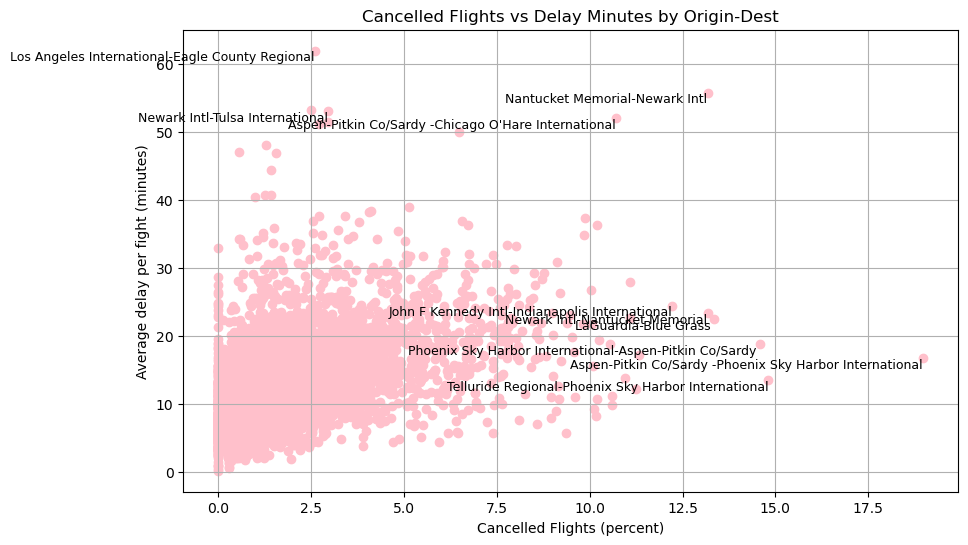

In [228]:
plt.figure(figsize=(10, 6))
plt.scatter(prob_origindest_100['percent_cancel'], prob_origindest_100['delay_per_flight'], color='pink')
###
for i, flight in prob_origindest_100.loc[[1763, 2255, 3179 , 2798,3166,3723,3844,4092,4171,4244]].iterrows():
        plt.text(flight['percent_cancel'], flight['delay_per_flight'], f"{flight['origin_airport']}-{flight['dest_airport']}",
             fontsize=9, ha='right', va='top')
###
plt.xlabel('Cancelled Flights (percent)')
plt.ylabel('Average delay per fight (minutes)')
plt.title('Cancelled Flights vs Delay Minutes by Origin-Dest')
plt.grid(True)
plt.show()

## Apache Superset
The default username and password is admin.

1. Adding and connecting to the database

![](images/ss_db.png)

### Example of a dashboard
The superset dashboard is a proof of concept for how a typical Hive-connected dashboard would look like. It is made up of several 'slices' that is possible to have 'refresh' at intervals. 

Below, the first slice counts the frequency of values in cancellationcode. The second slice counts total cancellations grouped by airport. The third and fourth slices is total delay (carrier, nas, weather, security, late aircraft delays added together) and then grouped by either month and day of month. This is a proof of concept.

![](images/dashboard.png)